# Libraries

In [34]:
import os
import sys
import random
import numpy as np
import matplotlib as plt
import contextlib
import traci
import math

Y = "\033[33m"  # Yellow color
E = "\033[0m"   # Reset formatting

# Environment

In [35]:
if 'SUMO_HOME' not in os.environ:
    os.environ['SUMO_HOME'] = '/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo'

tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
sys.path.append(tools)

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def Sumo_init(seed, Visualize=False):
    """
    Initialize the SUMO simulation environment.
    """
    seed = str(seed)
    if Visualize:
        Sumo_config = [
            '/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/bin/sumo-gui',
            '-c', 'Traci.sumocfg',
            '--no-step-log',
            '--no-warnings',
            '--step-length', '0.1',
            '--delay', '1000',
            '--lateral-resolution', '0.1',
            '--seed', seed,
        ]
    else:
        Sumo_config = [
            '/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/bin/sumo',
            '-c', 'Traci.sumocfg',
            '--no-step-log',
            '--no-warnings',
            '--step-length', '0.1',
            '--delay', '1000',
            '--lateral-resolution', '0.1',
            '--seed', seed,
        ]

    with suppress_output():
        traci.start(Sumo_config)

    return True

In [36]:
q_EB_0 = 0
q_EB_1 = 0
q_EB_2 = 0
#from south
q_SB_0 = 0
q_SB_1 = 0
q_SB_2 = 0
#from west
q_WB_0 = 0
q_WB_1 = 0
q_WB_2 = 0
#from north
q_NB_0 = 0
q_NB_1 = 0
q_NB_2 = 0
# current phase
current_phase = 0

detector_ids = ["Node5_4_EB_0", 
                "Node5_4_EB_1", 
                "Node5_4_EB_2", 
                "Node5_1_SB_0", 
                "Node5_1_SB_1", 
                "Node5_1_SB_2", 
                "Node5_2_WB_0", 
                "Node5_2_WB_1", 
                "Node5_2_WB_2", 
                "Node5_3_NB_0", 
                "Node5_3_NB_1", 
                "Node5_3_NB_2"]

traffic_light_id = "Node5"

ACTIONS = [0,1,2,3]
PHASES = [0,2,4,6]
NUM_ACTIONS = len(ACTIONS)

# Main Functions

In [37]:
def get_queue_length(detector_id, velocity_threshold = 0.1): 
    ''' Get the queue length from the detector.'''
    if isinstance(detector_id, list):
        '''Check if we have multiple detectors'''
        # Handle multiple detectors
        total_slow_vehicles = 0
        for det_id in detector_id:
            vehicle_ids = traci.lanearea.getLastStepVehicleIDs(det_id)  # Get vehicles detected by the detector
            #slow_vehicles = [v for v in vehicle_ids if traci.vehicle.getSpeed(v) <= velocity_threshold]
            slow_vehicles = [v for v in vehicle_ids if float(traci.vehicle.getSpeed(v)) <= velocity_threshold]       #type: ignore
            total_slow_vehicles += len(slow_vehicles)  # Add the count of slow vehicles
        return total_slow_vehicles
    else:
        # Handle a single detector ID
        vehicle_ids = traci.lanearea.getLastStepVehicleIDs(detector_id)  # Get vehicles detected by the detector
        slow_vehicles = [v for v in vehicle_ids if float(traci.vehicle.getSpeed(v)) <= velocity_threshold]          #type: ignore
            # If the speed is below the threshold, consider it as a queue
        # Count the number of slow vehicles
        queue_lenght = len(slow_vehicles)
        return queue_lenght


def get_current_phase(traffic_light_id):
    ''' Get the current traffic light phase.'''
    current_phase = traci.trafficlight.getPhase(traffic_light_id)
    return current_phase

def get_state(detector_ids, traffic_light_id):
    ''' Get the current state of the environment, including queue lenghts and current light phase.'''

        # Get queue lengths from each detector
    queue_lenghts  = [get_queue_length(det) for det in detector_ids]
    
    # Get current phase index
    current_phase = get_current_phase(traffic_light_id)

    state = tuple(queue_lenghts + [current_phase])
    
    #we return the state as a tuple containing queue lenghts and current phase
    return state

def calculate_reward(state):
    ''' We take the reduction in waiting time between two subsequent states as the reward.'''
    total_queue = sum(state[:-1])  
    reward = -float(total_queue)
    return reward

def cosine_decay_epsilon(t, T_max, eps_max=1.0, eps_min=0.01):
    cosine = math.cos(math.pi * t / T_max)
    return eps_min + 0.5 * (eps_max - eps_min) * (1 + cosine)

last_switch_step = 0  # definizione globale

def apply_action(current_step, current_phase, MIN_GREEN_STEPS=100):
    """
    action_idx: index in 0..NUM_ACTIONS-1
     - maps to actual phase via PHASES[action_idx]
    Enforces MIN_GREEN_STEPS on each green and one-step yellow transition.
    """
    global last_switch_step

    # If we are in a yellow phase, do not apply any action
    if current_phase % 2 == 1:
        # If the current phase is yellow (odd), we cannot apply an action
        return False

    if current_step - last_switch_step < MIN_GREEN_STEPS:  
        return False
    return True
  

# Q-Learning

In [38]:
Q_table = {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) : np.zeros(NUM_ACTIONS)}

In [39]:
def get_action_from_policy(state, EPSILON): 
    '''Balance exploration and exploitation.'''
    if state not in Q_table:
        Q_table[state] = np.zeros(NUM_ACTIONS)
        return int(random.choice(ACTIONS))
    if random.random() < EPSILON:
        return int(random.choice(ACTIONS))
    max_value = np.max(Q_table[state])
    max_indices = np.flatnonzero(Q_table[state] == max_value)
    return int(np.random.choice(max_indices))


def update_Q_table(old_state, action_idx, reward, new_state, ALPHA=0.1, GAMMA=0.95):
    ''' Update the Q-table using the Q-learning update rule.'''
    if old_state not in Q_table:
        Q_table[old_state] = np.zeros(NUM_ACTIONS)
    if new_state not in Q_table:
        Q_table[new_state] = np.zeros(NUM_ACTIONS)
    
    #Q-learning update rule
    Q_table[old_state][action_idx] = Q_table[old_state][action_idx] + ALPHA * (reward + GAMMA * np.max(Q_table[new_state]) - Q_table[old_state][action_idx])

In [40]:
def run_Q_learning_simulation(TOTAL_STEPS, detector_ids, traffic_light_id, EPSILON, training=True, Verbose= False, global_step=0):
    global last_switch_step
    cumulative_reward = 0.0
    step_history = []
    reward_history = []
    queue_history = []
    average_queue_length_for_step_history = []
    last_switch_step = 0.0
    step = 0



    try:
        while step < TOTAL_STEPS:
            state = get_state(detector_ids, traffic_light_id)
            #print(f"Current state: {state}")
            # 1) choose & apply action
            action_idx = get_action_from_policy(state, EPSILON)
            phase_code = PHASES[action_idx]
            current_phase = state[-1]  
            action_applied = apply_action(step, current_phase)

            # 2) advance SIM
            if action_applied:
                if phase_code != current_phase:  
                    current_phase = current_phase + 1 #type: ignore          
                    traci.trafficlight.setPhase(traffic_light_id, current_phase)  #type: ignore
                    #calculate new state and reward for 30 stepsù
                    for _ in range(30):
                        traci.simulationStep()
                        step += 1
                        new_state = get_state(detector_ids, traffic_light_id)
                        reward = calculate_reward(new_state)
                        cumulative_reward += reward
                        reward_history.append(reward)
                        step_history.append(step)
                        queue_lengths = [get_queue_length(det) for det in detector_ids]
                        queue_history.append(queue_lengths)
                        average_queue_length_for_step = sum(queue_lengths) / len(queue_lengths) if queue_lengths else 0
                        average_queue_length_for_step_history.append(average_queue_length_for_step)
                    
                    # Step to apply the new phase
                    traci.trafficlight.setPhase(traffic_light_id, phase_code)
                    last_switch_step = step

                traci.simulationStep()
                step += 1
                new_state = get_state(detector_ids, traffic_light_id)
                reward = calculate_reward(new_state)

                if training:
                    update_Q_table(state, action_idx, reward, new_state)
                

            else: 
                traci.simulationStep()
                step += 1
                # 3) observe next state & reward
                new_state = get_state(detector_ids, traffic_light_id)
                reward = calculate_reward(new_state)



                # 5) decay epsilon
            if training:
                EPSILON = cosine_decay_epsilon(global_step + step, TOTAL_STEPS*10, eps_max=1.0, eps_min=0.01)

            step_history.append(step)
            cumulative_reward += reward
            reward_history.append(reward)
            queue_lengths = [get_queue_length(det) for det in detector_ids]
            queue_history.append(queue_lengths)
            average_queue_length_for_step = sum(queue_lengths) / len(queue_lengths) if queue_lengths else 0
            average_queue_length_for_step_history.append(average_queue_length_for_step)

            if Verbose == True:
                if step % 100 == 0:
                    print(f"{Y}Step {step}/{TOTAL_STEPS}, Epsilon: {EPSILON:.4f}, Cumulative Reward: {cumulative_reward:.2f}{E}, Queue Lengths: {new_state[:3]}, Action: {action_idx}")

        average_queue_length = np.mean([sum(q) if isinstance(q, (list, tuple)) else q for q in queue_history])
        print(f"{Y}Cumulative Reward: {cumulative_reward:.2f}, Average Queue Length: {average_queue_length:.2f}{E}, Epsilon: {EPSILON:.4f}")

    except KeyboardInterrupt:
        print(f"{Y}Simulation interrupted by user.{E}")
    
    finally:
        if traci.isLoaded():
            traci.close()

    if training:
        return  reward_history, average_queue_length_for_step_history, cumulative_reward, average_queue_length, EPSILON, step

    return step_history, reward_history, queue_history, average_queue_length_for_step_history, cumulative_reward, average_queue_length, EPSILON, step

## Training

In [41]:
EPSILON = 1.0
global_step = 0
average_reward_Q_training = []
average_queue_length_on_seeds_Q_training = []
all_queues_Q_training = []
all_rewards_Q_training = []
for i in range(10):
    print(f"{Y}Running simulation with seed {i}{E}")
    Sumo_init(i)
    reward_history_Q_training, average_queue_length_for_step_history_Q_training, cumulative_reward_Q_training, average_queue_length_Q_training, EPSILON, step_run = run_Q_learning_simulation(80000, detector_ids, traffic_light_id, EPSILON=EPSILON, training=True, Verbose=False, global_step=global_step)

    global_step += step_run
    all_queues_Q_training.extend(average_queue_length_for_step_history_Q_training)
    all_rewards_Q_training.extend(reward_history_Q_training)
    average_reward_Q_training.append(cumulative_reward_Q_training)
    average_queue_length_on_seeds_Q_training.append(average_queue_length_Q_training)
    print('--' * 50)

Running simulation with seed 0


Cumulative Reward: -416180.00, Average Queue Length: 5.20, Epsilon: 0.9758
----------------------------------------------------------------------------------------------------
Running simulation with seed 1


Cumulative Reward: -414196.00, Average Queue Length: 5.18, Epsilon: 0.9055
----------------------------------------------------------------------------------------------------
Running simulation with seed 2


Cumulative Reward: -403969.00, Average Queue Length: 5.05, Epsilon: 0.7959
----------------------------------------------------------------------------------------------------
Running simulation with seed 3


Cumulative Reward: -374266.00, Average Queue Length: 4.68, Epsilon: 0.6579
----------------------------------------------------------------------------------------------------
Running simulation with seed 4


Cumulative Reward: -421702.00, Average Queue Length: 5.27, Epsilon: 0.5049
----------------------------------------------------------------------------------------------------
Running simulation with seed 5


Cumulative Reward: -342594.00, Average Queue Length: 4.28, Epsilon: 0.3520
----------------------------------------------------------------------------------------------------
Running simulation with seed 6


Cumulative Reward: -430617.00, Average Queue Length: 5.38, Epsilon: 0.2140
----------------------------------------------------------------------------------------------------
Running simulation with seed 7


Cumulative Reward: -412397.00, Average Queue Length: 5.15, Epsilon: 0.1045
----------------------------------------------------------------------------------------------------
Running simulation with seed 8


Cumulative Reward: -324376.00, Average Queue Length: 4.05, Epsilon: 0.0342
----------------------------------------------------------------------------------------------------
Running simulation with seed 9


Cumulative Reward: -376098.00, Average Queue Length: 4.70, Epsilon: 0.0100
----------------------------------------------------------------------------------------------------


In [42]:
print(f"{Y}Final Q-table:{E}")
for state, actions in Q_table.items():
    print(f"State {state}: {actions}")

Final Q-table:
State (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): [-0.43842716 -0.5274433  -0.45393163 -0.37579227]
State (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): [0. 0. 0. 0.]
State (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2): [-0.34078855 -0.21258454 -0.31478521 -0.21041779]
State (1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2): [-0.22925458  0.         -0.3        -0.2       ]
State (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2): [-0.21433745 -0.2985025  -0.30764422 -0.4978    ]
State (1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2): [-0.01535135 -0.2        -0.56005     0.        ]
State (1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2): [-0.16054274 -0.2        -0.20983042 -0.3       ]
State (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0): [-0.57673859 -0.4249     -0.55626045 -0.43762061]
State (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): [-0.38580877 -0.32547886 -0.78038624 -0.43661   ]
State (0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0): [-0.399      -0.43661    -0.35330179 -0.38      ]
State (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): [0. 

In [43]:
# print final Q-table shape
print(f"{Y}Final Q-table shape: {len(Q_table)} states, {NUM_ACTIONS} actions per state.{E}")

Final Q-table shape: 16764 states, 4 actions per state.


In [44]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 8))  

# Primo subplot: Average Cumulative Reward
axes[0].plot(range(10, 20), average_reward_Q_training, marker='o', color='blue', label='Average Cumulative Reward')
axes[0].set_title('Average Cumulative Reward over Seeds (Training)')
axes[0].set_xlabel('Seed')
axes[0].set_ylabel('Average Cumulative Reward')
axes[0].set_xticks(range(10, 20))
axes[0].grid(True)

# Secondo subplot: Average Queue Length
axes[1].plot(range(10, 20), average_queue_length_on_seeds_Q_training, marker='o', color='red', label='Average Queue Length')
axes[1].set_title('Average Queue Length over Seeds (Training)')
axes[1].set_xlabel('Seed')
axes[1].set_ylabel('Average Queue Length')
axes[1].set_xticks(range(10, 20))
axes[1].grid(True)

# Ottimizza layout e salva
plt.tight_layout()
plt.savefig('comparison_over_seeds.png')
plt.show()

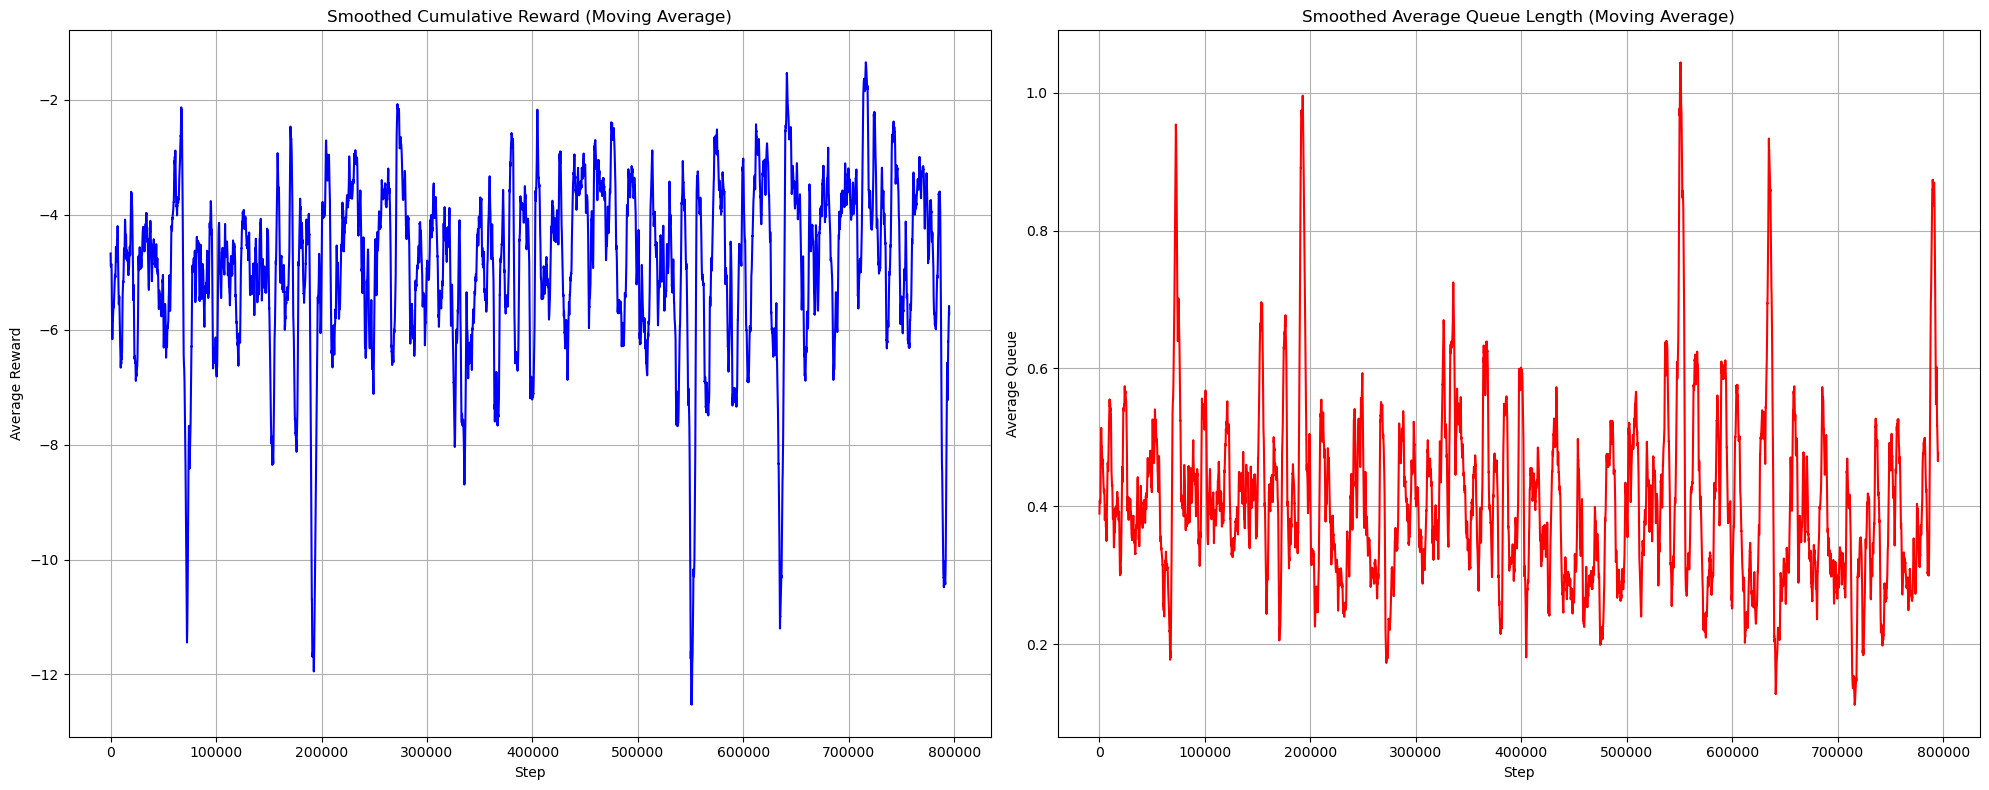

In [45]:
def moving_average(data, window_size=5000):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

ma_rewards = moving_average(all_rewards_Q_training)
ma_queues = moving_average(all_queues_Q_training)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Smoothed Reward Plot
axes[0].plot(ma_rewards, color='blue')
axes[0].set_title("Smoothed Cumulative Reward (Moving Average)")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Average Reward")
axes[0].grid(True)

# Smoothed Queue Length Plot
axes[1].plot(ma_queues, color='red')
axes[1].set_title("Smoothed Average Queue Length (Moving Average)")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Average Queue")
axes[1].grid(True)

plt.tight_layout()
plt.savefig("smoothed_metrics_over_all_steps.png")
plt.show()

## Testing

In [46]:
average_reward_Q = []
average_queue_length_on_seeds_Q = []
all_queues_Q = []
all_rewards_Q = []
for i in range(10,20):
    print(f"{Y}Running simulation with seed {i}{E}")
    Sumo_init(i)
    step_history_Q, reward_history_Q, queue_history_Q, average_queue_length_for_step_history_Q, cumulative_reward_Q, average_queue_length_Q, EPSILON, step = run_Q_learning_simulation(20000, detector_ids, traffic_light_id, EPSILON=0.0, training=False, Verbose=False)
    average_reward_Q.append(cumulative_reward_Q)
    average_queue_length_on_seeds_Q.append(average_queue_length_Q)
    print('--' * 50)
    all_queues_Q.extend(average_queue_length_for_step_history_Q)
    all_rewards_Q.extend(reward_history_Q)


# Print the average cumulative reward and average queue length over 10 runs
print(f"{Y}Average Cumulative Reward over 10 runs: {np.mean(average_reward_Q):.2f}, Standard Deviation: {np.std(average_reward_Q):.2f}{E}")
#compute standard deviation of average reward
print(f"{Y}Average Queue Length over 10 runs: {np.mean(average_queue_length_on_seeds_Q):.2f}{E}")

Running simulation with seed 10


Cumulative Reward: -86877.00, Average Queue Length: 4.34, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 11


Cumulative Reward: -83041.00, Average Queue Length: 4.15, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 12


Cumulative Reward: -65559.00, Average Queue Length: 3.28, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 13


Cumulative Reward: -67452.00, Average Queue Length: 3.37, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 14


Cumulative Reward: -79327.00, Average Queue Length: 3.96, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 15


Cumulative Reward: -125066.00, Average Queue Length: 6.25, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 16


Cumulative Reward: -94802.00, Average Queue Length: 4.74, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 17


Cumulative Reward: -102918.00, Average Queue Length: 5.15, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 18


Cumulative Reward: -70882.00, Average Queue Length: 3.54, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 19


Cumulative Reward: -87113.00, Average Queue Length: 4.36, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Average Cumulative Reward over 10 runs: -86303.70, Standard Deviation: 17130.77
Average Queue Length over 10 runs: 4.31


In [47]:

#print shape 
print(f"{Y}Shape of all rewards: {np.shape(all_rewards_Q)}{E}")

Shape of all rewards: (200039,)


In [48]:
#print shape of all queues
print(f"{Y}Shape of all queues: {np.shape(all_queues_Q)}{E}")
#print shape step history
print(f"{Y}Shape of step history: {np.shape(step_history_Q)}{E}")

#print shape of reward history
print(f"{Y}Shape of reward history: {np.shape(reward_history_Q)}{E}")

#print shape of queue history  
print(f"{Y}Shape of queue history: {np.shape(queue_history_Q)}{E}")

Shape of all queues: (200039,)
Shape of step history: (20000,)
Shape of reward history: (20000,)
Shape of queue history: (20000, 12)


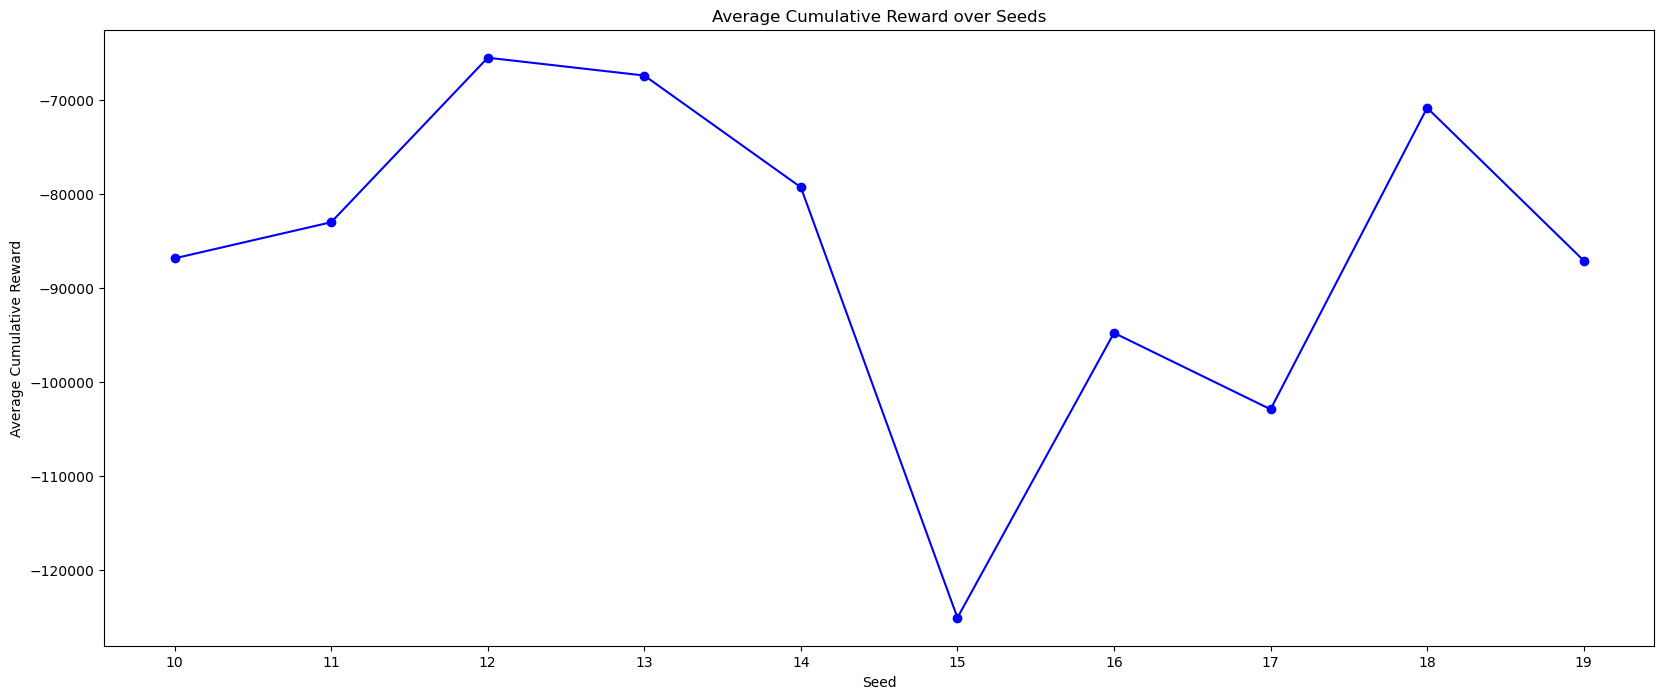

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_reward_Q, marker='o', color='blue', label='Average Cumulative Reward')
plt.title('Average Cumulative Reward over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Cumulative Reward')
plt.xticks(range(10, 20))

plt.savefig('average_cumulative_reward_over_seeds.png')

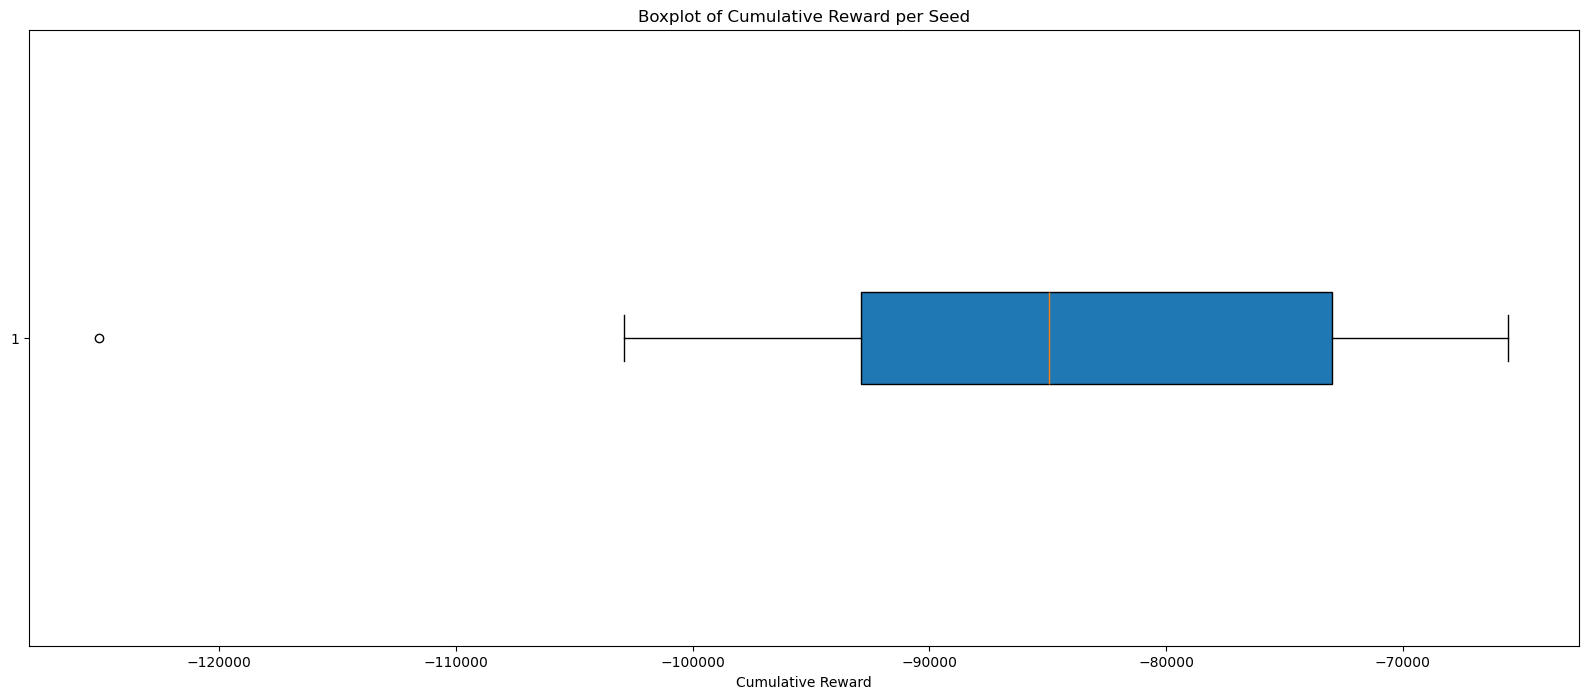

In [50]:
# boxplot cumulative reward per seed
plt.figure(figsize=(20, 8))
plt.boxplot(average_reward_Q, vert=False, patch_artist=True)
plt.title('Boxplot of Cumulative Reward per Seed')
plt.xlabel('Cumulative Reward')
plt.savefig('boxplot_cumulative_reward_per_seed.png')

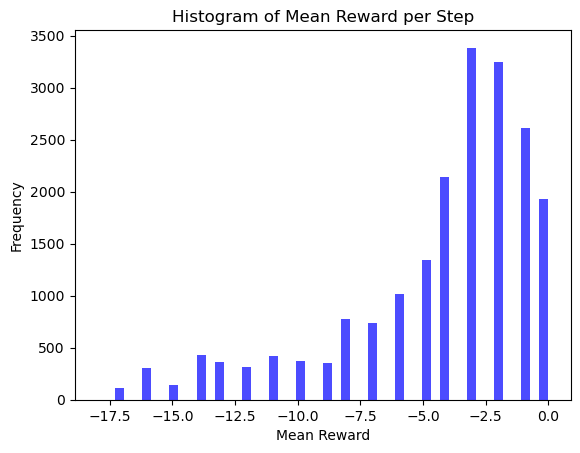

In [51]:
# histogram mean reward per step
plt.hist(reward_history_Q, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Mean Reward per Step')
plt.xlabel('Mean Reward')
plt.ylabel('Frequency')
plt.savefig('histogram_mean_reward_per_step.png')

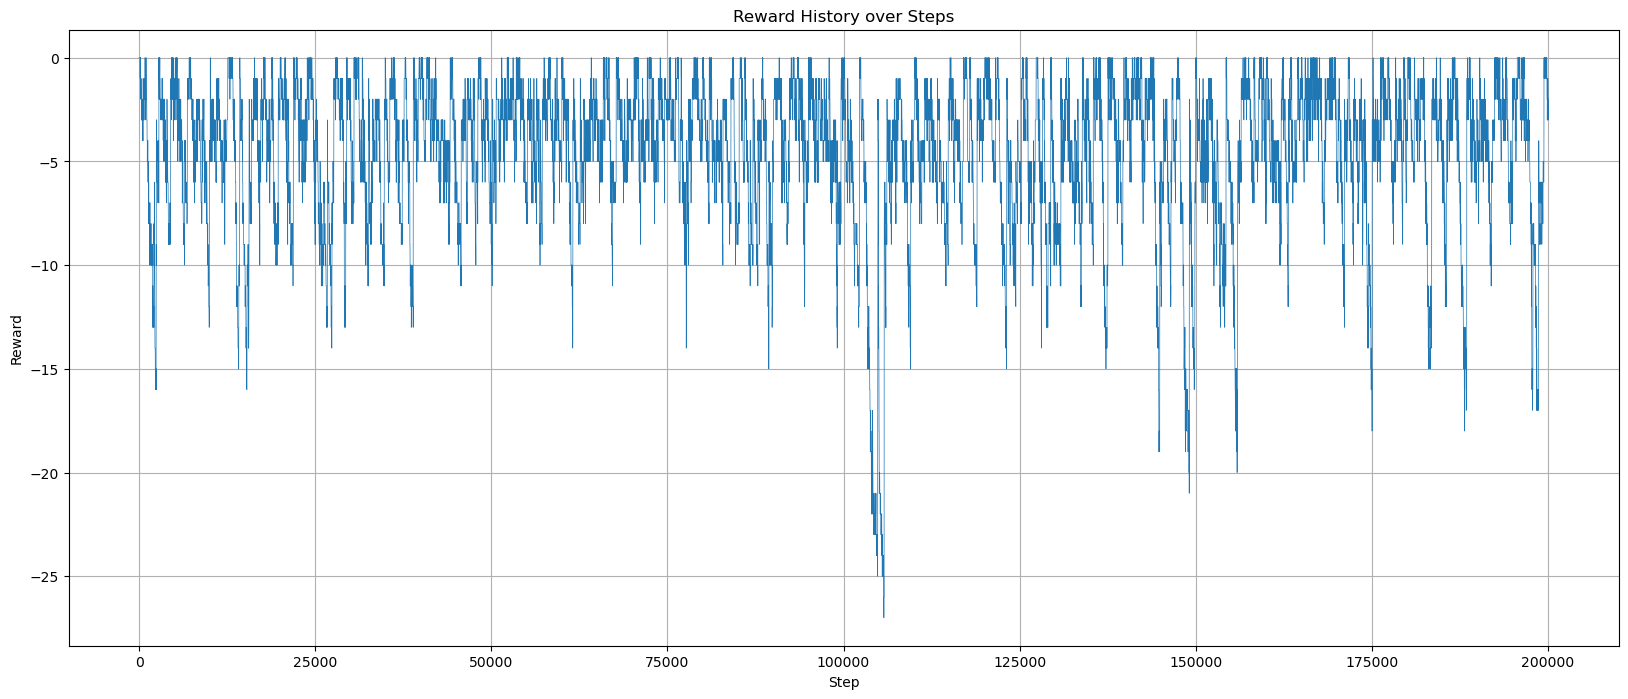

In [52]:
steps = list(range(len(all_rewards_Q)))
plt.figure(figsize=(20, 8))
plt.plot(steps, all_rewards_Q, linewidth=0.5)
plt.title('Reward History over Steps')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.grid()
plt.savefig('reward_history_over_steps.png')

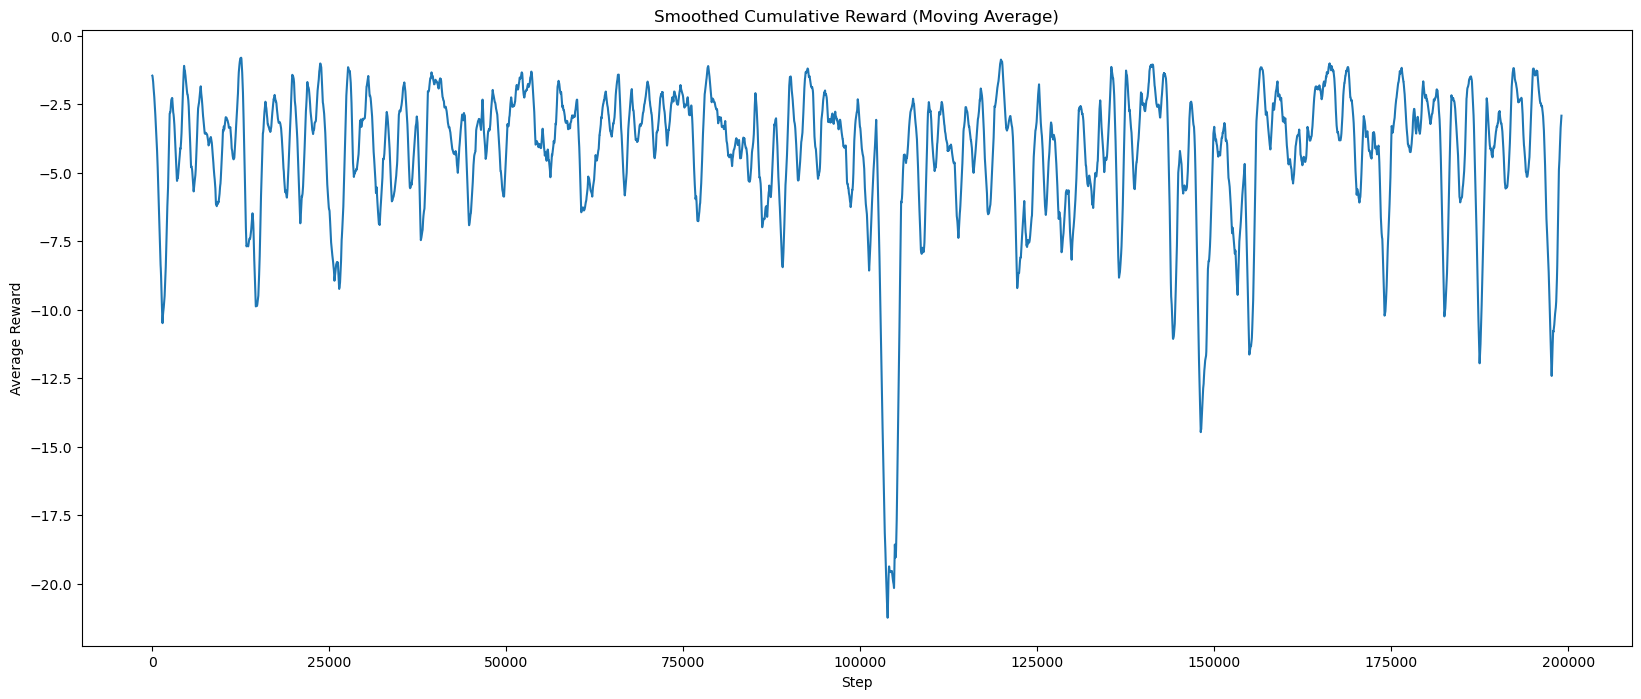

In [53]:
import numpy as np

def moving_average(data, window_size=1000):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

ma_rewards = moving_average(all_rewards_Q)

plt.figure(figsize=(20, 8))
plt.plot(ma_rewards)
plt.title("Smoothed Cumulative Reward (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.savefig("smoothed_reward_over_all_steps.png")

In [54]:
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_queue_length_on_seeds_Q, marker='o', color='red', label='Average Queue Length')
plt.title('Average Queue Length over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Queue Length')
plt.xticks(range(10, 20))
plt.savefig('average_queue_length_over_seeds.png')

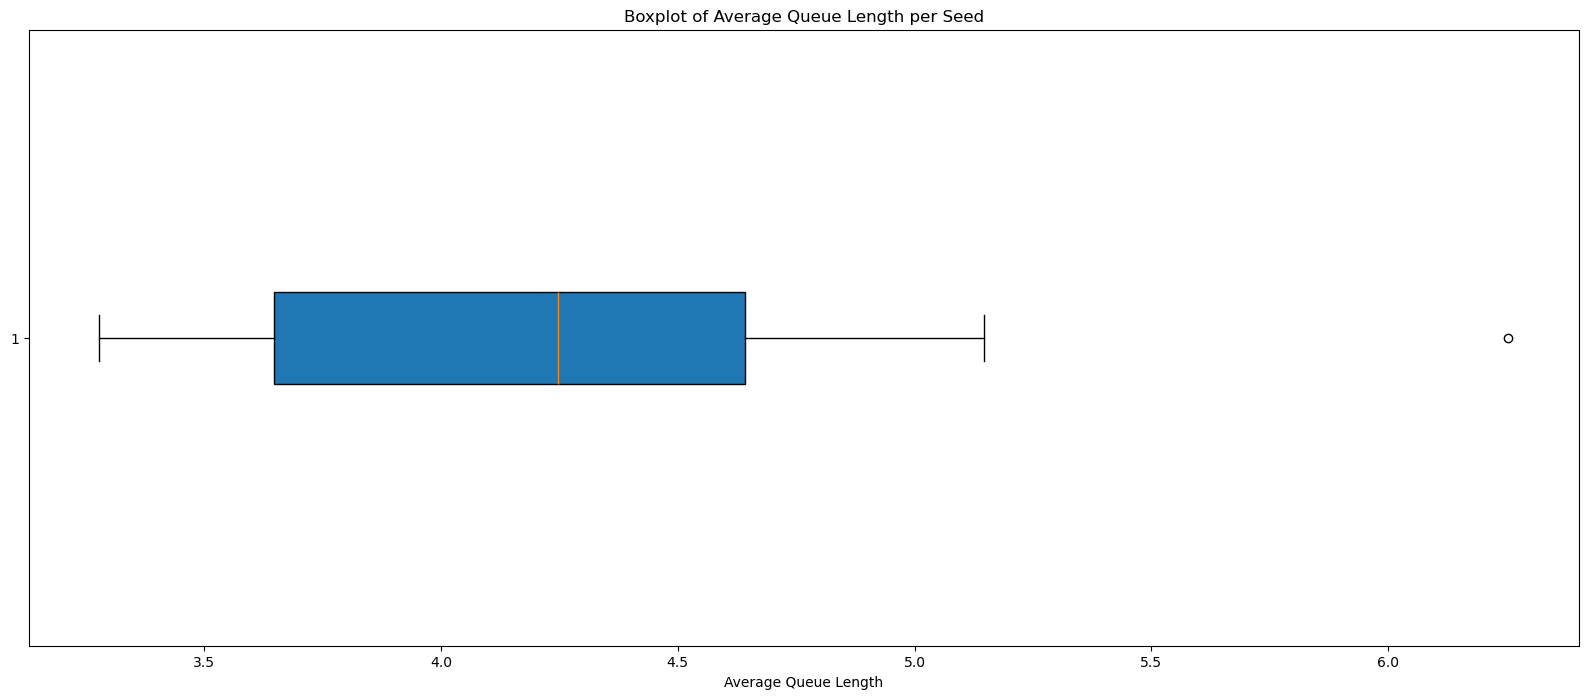

In [55]:
# boxplot average queue length per seed
plt.figure(figsize=(20, 8))
plt.boxplot(average_queue_length_on_seeds_Q, vert=False, patch_artist=True)
plt.title('Boxplot of Average Queue Length per Seed')
plt.xlabel('Average Queue Length')
plt.savefig('boxplot_average_queue_length_per_seed.png')

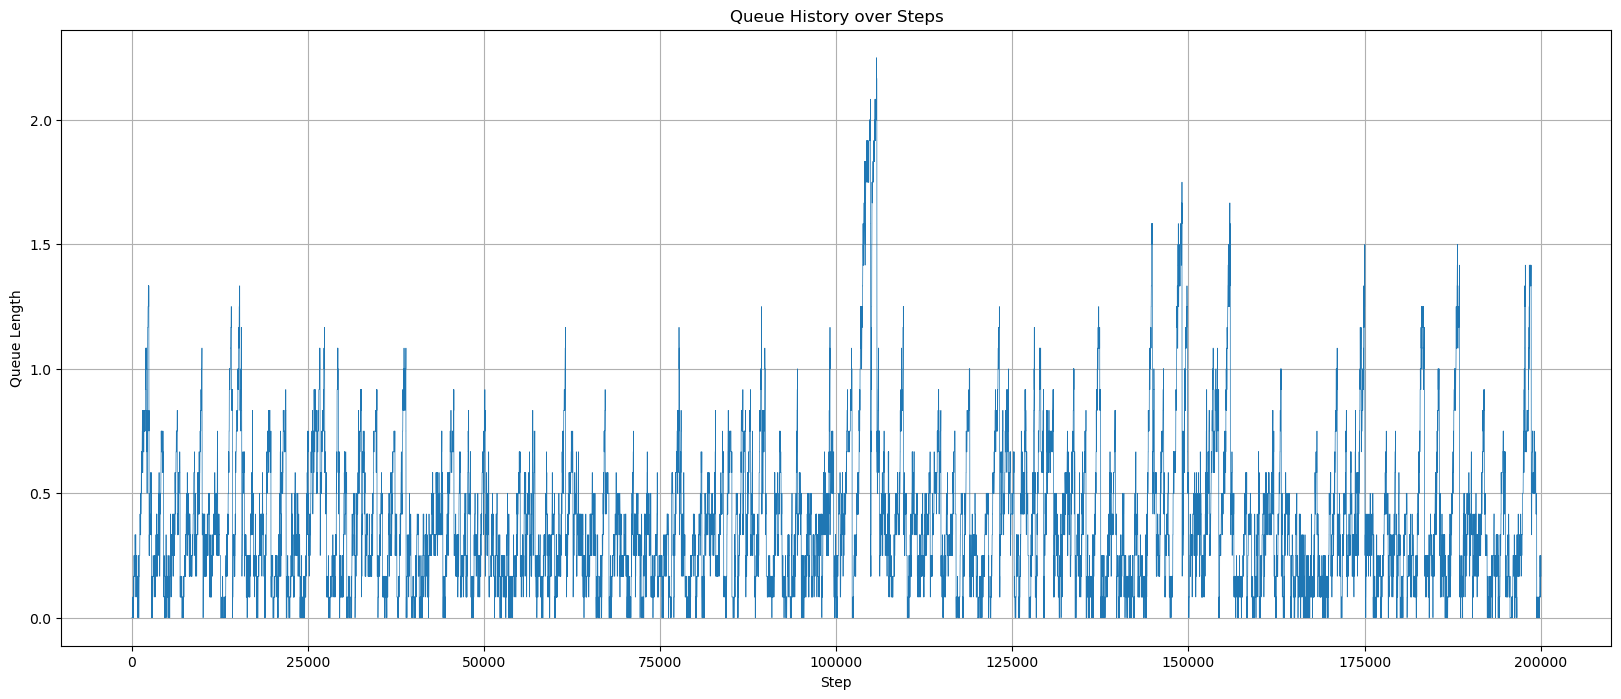

In [56]:
steps = list(range(len(all_queues_Q)))
plt.figure(figsize=(20, 8))
plt.plot(steps, all_queues_Q, linewidth=0.5)
plt.title('Queue History over Steps')
plt.xlabel('Step')
plt.ylabel('Queue Length')
plt.grid()
plt.savefig('reward_history_over_steps.png')

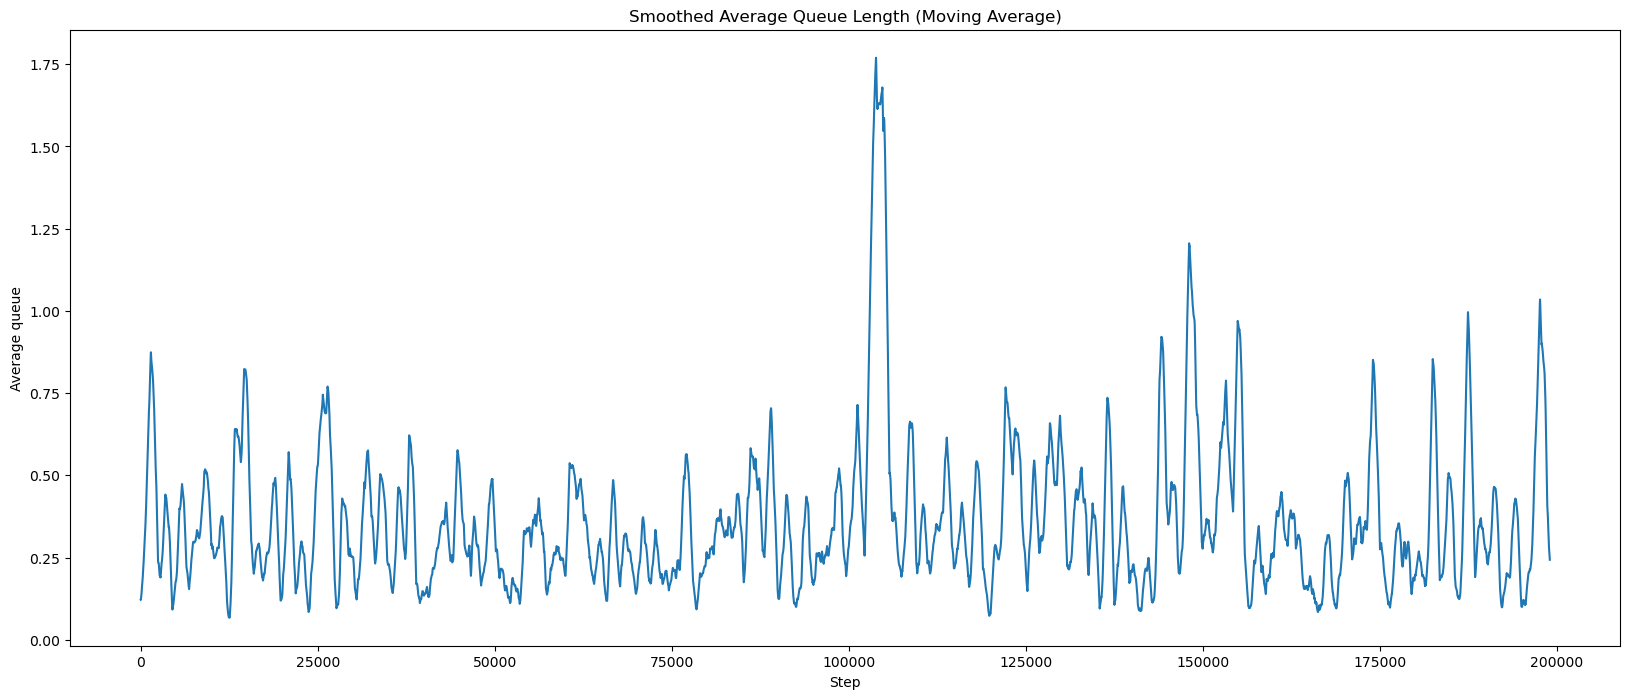

In [57]:
ma_queues = moving_average(all_queues_Q)

plt.figure(figsize=(20, 8))
plt.plot(ma_queues)
plt.title("Smoothed Average Queue Length (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average queue")
plt.savefig("smoothed_reward_over_all_steps.png")

# Deep Q-Learning


In [6]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import math

In [7]:
# Device selection
device = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("cpu")
)

In [8]:
print(f"Using device: {device}")

Using device: mps


In [9]:
# Hyperparams
TRAIN_FREQ = 4
BATCH_SIZE = 128
TARGET_UPDATE_FREQ = 1000  
REPLAY_BUFFER_SIZE = 100000
GAMMA = 0.95
ALPHA = 1e-3
MIN_REPLAY_SIZE = 2000

train_calls = 0
state_size = 13 


In [10]:
Experience = namedtuple("Experience", ["s", "a", "r", "s2"])

In [11]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buf = deque(maxlen=capacity)
    def __len__(self):
        return len(self.buf)
    def append(self, exp):
        self.buf.append(exp)
    def sample(self, n):
        exps = random.sample(self.buf, n)
        return Experience(*zip(*exps))

class DQN(nn.Module):
    def __init__(self, n_states, n_actions, hidden=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_states, hidden),
            nn.LayerNorm(hidden),
            nn.GELU(),
            #nn.Dropout(0.1),

            #nn.Linear(hidden, hidden),
            #nn.LayerNorm(hidden),
            #nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(hidden, n_actions)
        )
    def forward(self, x):
        return self.net(x)

actions_taken = [0,0,0,0]

def select_action(model, state, EPSILON):
    global actions_taken
    if random.random() < EPSILON:
        return random.randrange(NUM_ACTIONS)
    with torch.no_grad():
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = int(model(s).argmax(1).item())
        actions_taken[action] += 1
        return action
    

def cosine_decay_epsilon(t, T_max, eps_max=1.0, eps_min=0.01):
    cosine = math.cos(math.pi * t / T_max)
    return eps_min + 0.5 * (eps_max - eps_min) * (1 + cosine)

def optimize(current_net, target_net, optimizer, buffer):
    if len(buffer) < BATCH_SIZE:
        return None
    batch = buffer.sample(BATCH_SIZE)
    s  = torch.tensor(batch.s,  dtype=torch.float32, device=device)
    a  = torch.tensor(batch.a,  dtype=torch.int64, device=device).unsqueeze(1)
    r  = torch.tensor(batch.r,  dtype=torch.float32, device=device).unsqueeze(1)
    s2 = torch.tensor(batch.s2, dtype=torch.float32, device=device)

    q  = current_net(s).gather(1, a)
    with torch.no_grad():
        q2 = target_net(s2).max(1)[0].unsqueeze(1)
        y  = r + GAMMA * q2

    loss = nn.functional.mse_loss(q, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [12]:
def run_simulation_DQL(
        TOTAL_STEPS, detector_ids, traffic_light_id,
        q_net, target_net, replay_buf, optimizer,
        EPSILON=1.0, training=True, Verbose=False,
        global_step=0):
    global last_switch_step
    
    step = 0
    train_calls = 0
    step_history = []
    reward_history = []
    queue_history = []
    average_queue_length_for_step_history = []    
    cumulative_reward = 0.0
    last_switch_step = 0.0

    try: 
        if training:
            q_net.train()
            target_net.train()
        else:
            q_net.eval()
            target_net.eval()

        while step < TOTAL_STEPS:
            # 1) observe state & select action
            state = get_state(detector_ids, traffic_light_id)
            action_idx = select_action(q_net, state, EPSILON)
            phase_code = PHASES[action_idx]
            current_phase = state[-1]
            action_applied = apply_action(step, current_phase)


            # 2) execute on SUMO
            if action_applied:
                if phase_code != current_phase:
                    current_phase = current_phase + 1
                    traci.trafficlight.setPhase(traffic_light_id, current_phase)
                    for _ in range(30):
                        traci.simulationStep()
                        step += 1
                        new_state = get_state(detector_ids, traffic_light_id)
                        reward = calculate_reward(new_state)
                        reward_history.append(reward)
                        cumulative_reward += reward
                        step_history.append(step)
                        queue_lengths = [get_queue_length(det) for det in detector_ids]
                        queue_history.append(queue_lengths)
                        average_queue_length_for_step = sum(queue_lengths) / len(queue_lengths) if queue_lengths else 0
                        average_queue_length_for_step_history.append(average_queue_length_for_step)

                    traci.trafficlight.setPhase(traffic_light_id, phase_code)
                    last_switch_step = step

                traci.simulationStep()
                step += 1
                new_state = get_state(detector_ids, traffic_light_id)
                reward = calculate_reward(new_state)

                if training:
                        replay_buf.append(Experience(state, action_idx, reward, new_state))
                        if step % TRAIN_FREQ == 0 and len(replay_buf) >= MIN_REPLAY_SIZE:
                            loss = optimize(q_net, target_net, optimizer, replay_buf)
                            train_calls += 1
                            if train_calls % (TARGET_UPDATE_FREQ // TRAIN_FREQ) == 0:
                                target_net.load_state_dict(q_net.state_dict())

            else:
                traci.simulationStep()
                step += 1
                new_state = get_state(detector_ids, traffic_light_id)
                reward = calculate_reward(new_state)

            if training:
                #EPSILON = max(eps_min, EPSILON * eps_decay)
                EPSILON = cosine_decay_epsilon(global_step + step, TOTAL_STEPS*10, eps_max=1.0, eps_min=0.01)

            cumulative_reward += reward
            reward_history.append(reward)
            step_history.append(step)

            queue_lengths = [get_queue_length(det) for det in detector_ids]
            queue_history.append(queue_lengths)
            average_queue_length_for_step = sum(queue_lengths) / len(queue_lengths) if queue_lengths else 0
            average_queue_length_for_step_history.append(average_queue_length_for_step)

            if Verbose and step % 20000 == 0:
                print(f"{Y}Step {step}/{TOTAL_STEPS}, Epsilon: {EPSILON:.4f}, Cumulative Reward: {cumulative_reward:.2f}{E}, Queue Lengths: {new_state[:12]}, Action: {action_idx}")
            
        average_queue_length = np.mean([sum(q) if isinstance(q, (list, tuple)) else q for q in queue_history])
        print(f"{Y}Cumulative Reward: {cumulative_reward:.2f}, Average Queue Length: {average_queue_length:.2f}{E}, Epsilon: {EPSILON:.4f}")

    except KeyboardInterrupt:
        print(f"{Y}Simulation interrupted by user.{E}")
    finally:
        traci.close()


    if training:
        return  reward_history, average_queue_length_for_step_history, cumulative_reward, average_queue_length, EPSILON, step

    return step_history, reward_history, queue_history, average_queue_length_for_step_history, cumulative_reward, average_queue_length, EPSILON, step

In [13]:
# --- init networks, buffer & optimizer ---
q_net      = DQN(state_size, NUM_ACTIONS).to(device)
optimizer  = optim.Adam(q_net.parameters(), lr=ALPHA)
target_net = DQN(state_size, NUM_ACTIONS).to(device)
target_net.load_state_dict(q_net.state_dict())
train_calls = 0

replay_buf = ReplayBuffer(REPLAY_BUFFER_SIZE)
optimizer  = optim.Adam(q_net.parameters(), lr=ALPHA)

## Training

In [14]:
EPSILON = 1.0
global_step = 0
average_reward_DQL_training = []
average_queue_length_on_seeds_DQL_training = []
all_rewards_DQL_training = []
all_queues_DQL_training = []
for seed in range(10):
    print(f"{Y}Running simulation with seed {seed}{E}")
    actions_taken = [0, 0, 0, 0]
    Sumo_config = Sumo_init(seed, Visualize=False)
    #keep epsilon 1 for the firsts two seed
    reward_history_DQL_training, average_queue_length_for_step_history_DQL_training, cumulative_reward_DQL_training, average_queue_length_DQL_training, EPSILON, step_run = run_simulation_DQL(
        100000, detector_ids, traffic_light_id,
        q_net, target_net, replay_buf, optimizer,
        EPSILON = EPSILON, training=True, Verbose=True, global_step=global_step,
    )
    global_step += step_run
    all_queues_DQL_training.extend(average_queue_length_for_step_history_DQL_training)
    all_rewards_DQL_training.extend(reward_history_DQL_training)
    average_reward_DQL_training.append(cumulative_reward_DQL_training)
    average_queue_length_on_seeds_DQL_training.append(average_queue_length_DQL_training)
    print(f"{Y}Actions taken: {actions_taken}{'#888822'}")
    print("-" * 50)


print("Training complete on", device)

Running simulation with seed 0


Step 20000/100000, Epsilon: 0.9990, Cumulative Reward: -98994.00, Queue Lengths: (0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0), Action: 2
Step 60000/100000, Epsilon: 0.9912, Cumulative Reward: -323656.00, Queue Lengths: (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0), Action: 1
Step 100000/100000, Epsilon: 0.9758, Cumulative Reward: -514905.00, Queue Lengths: (0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Cumulative Reward: -514905.00, Average Queue Length: 5.15, Epsilon: 0.9758
Actions taken: [25, 243, 129, 262]#888822
--------------------------------------------------
Running simulation with seed 1


Step 20000/100000, Epsilon: 0.9652, Cumulative Reward: -106379.00, Queue Lengths: (2, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0), Action: 2
Step 40000/100000, Epsilon: 0.9529, Cumulative Reward: -212331.00, Queue Lengths: (2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1), Action: 0
Step 60000/100000, Epsilon: 0.9388, Cumulative Reward: -313728.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0), Action: 2
Step 80000/100000, Epsilon: 0.9229, Cumulative Reward: -410224.00, Queue Lengths: (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), Action: 0
Step 100000/100000, Epsilon: 0.9055, Cumulative Reward: -498218.00, Queue Lengths: (0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1), Action: 3
Cumulative Reward: -498218.00, Average Queue Length: 4.98, Epsilon: 0.9055
Actions taken: [247, 1971, 525, 1514]#888822
--------------------------------------------------
Running simulation with seed 2


Step 20000/100000, Epsilon: 0.8864, Cumulative Reward: -106535.00, Queue Lengths: (2, 2, 0, 1, 1, 0, 1, 1, 0, 3, 3, 0), Action: 3
Step 60000/100000, Epsilon: 0.8439, Cumulative Reward: -291697.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1), Action: 1
Step 100000/100000, Epsilon: 0.7960, Cumulative Reward: -435796.00, Queue Lengths: (1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0), Action: 0
Cumulative Reward: -435796.00, Average Queue Length: 4.36, Epsilon: 0.7960
Actions taken: [4989, 816, 4043, 1249]#888822
--------------------------------------------------
Running simulation with seed 3


Step 20000/100000, Epsilon: 0.7702, Cumulative Reward: -76243.00, Queue Lengths: (0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0), Action: 1
Step 40000/100000, Epsilon: 0.7435, Cumulative Reward: -145808.00, Queue Lengths: (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0), Action: 2
Step 60000/100000, Epsilon: 0.7158, Cumulative Reward: -225035.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0), Action: 0
Step 80000/100000, Epsilon: 0.6872, Cumulative Reward: -287593.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1), Action: 0
Step 100000/100000, Epsilon: 0.6580, Cumulative Reward: -351464.00, Queue Lengths: (0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 1, 0), Action: 1
Cumulative Reward: -351464.00, Average Queue Length: 3.51, Epsilon: 0.6580
Actions taken: [8874, 1948, 7780, 2318]#888822
--------------------------------------------------
Running simulation with seed 4


Step 20000/100000, Epsilon: 0.6281, Cumulative Reward: -58253.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1), Action: 2
Step 40000/100000, Epsilon: 0.5978, Cumulative Reward: -135417.00, Queue Lengths: (0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0), Action: 2
Step 80000/100000, Epsilon: 0.5361, Cumulative Reward: -246005.00, Queue Lengths: (1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0), Action: 1
Step 100000/100000, Epsilon: 0.5050, Cumulative Reward: -318479.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Cumulative Reward: -318479.00, Average Queue Length: 3.18, Epsilon: 0.5050
Actions taken: [13237, 4011, 11371, 3411]#888822
--------------------------------------------------
Running simulation with seed 5


Step 20000/100000, Epsilon: 0.4739, Cumulative Reward: -51062.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 3
Step 40000/100000, Epsilon: 0.4430, Cumulative Reward: -108987.00, Queue Lengths: (0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0), Action: 3
Step 80000/100000, Epsilon: 0.3819, Cumulative Reward: -209532.00, Queue Lengths: (0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 3), Action: 3
Step 100000/100000, Epsilon: 0.3520, Cumulative Reward: -264557.00, Queue Lengths: (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0), Action: 2
Cumulative Reward: -264557.00, Average Queue Length: 2.65, Epsilon: 0.3520
Actions taken: [18412, 5415, 14320, 5674]#888822
--------------------------------------------------
Running simulation with seed 6


Step 20000/100000, Epsilon: 0.3228, Cumulative Reward: -60139.00, Queue Lengths: (0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1), Action: 0
Step 40000/100000, Epsilon: 0.2942, Cumulative Reward: -108828.00, Queue Lengths: (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0), Action: 2
Step 60000/100000, Epsilon: 0.2665, Cumulative Reward: -157855.00, Queue Lengths: (0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0), Action: 2
Step 80000/100000, Epsilon: 0.2398, Cumulative Reward: -208902.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Step 100000/100000, Epsilon: 0.2140, Cumulative Reward: -256665.00, Queue Lengths: (1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2), Action: 3
Cumulative Reward: -256665.00, Average Queue Length: 2.57, Epsilon: 0.2140
Actions taken: [22627, 8158, 16945, 7635]#888822
--------------------------------------------------
Running simulation with seed 7


Step 20000/100000, Epsilon: 0.1895, Cumulative Reward: -53440.00, Queue Lengths: (0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0), Action: 2
Step 40000/100000, Epsilon: 0.1661, Cumulative Reward: -99726.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0), Action: 0
Step 80000/100000, Epsilon: 0.1236, Cumulative Reward: -182531.00, Queue Lengths: (1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0), Action: 0
Step 100000/100000, Epsilon: 0.1045, Cumulative Reward: -228495.00, Queue Lengths: (1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0), Action: 0
Cumulative Reward: -228495.00, Average Queue Length: 2.28, Epsilon: 0.1045
Actions taken: [23729, 9316, 21880, 10015]#888822
--------------------------------------------------
Running simulation with seed 8


Step 20000/100000, Epsilon: 0.0871, Cumulative Reward: -42435.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0), Action: 1
Step 40000/100000, Epsilon: 0.0712, Cumulative Reward: -85435.00, Queue Lengths: (0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 2), Action: 2
Step 60000/100000, Epsilon: 0.0571, Cumulative Reward: -129924.00, Queue Lengths: (0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0), Action: 0
Step 80000/100000, Epsilon: 0.0448, Cumulative Reward: -170266.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 1
Step 100000/100000, Epsilon: 0.0342, Cumulative Reward: -213421.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Cumulative Reward: -213421.00, Average Queue Length: 2.13, Epsilon: 0.0342
Actions taken: [24748, 12353, 25303, 9485]#888822
--------------------------------------------------
Running simulation with seed 9


Step 20000/100000, Epsilon: 0.0256, Cumulative Reward: -38696.00, Queue Lengths: (1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0), Action: 0
Step 80000/100000, Epsilon: 0.0110, Cumulative Reward: -150646.00, Queue Lengths: (0, 0, 0, 2, 0, 0, 0, 0, 2, 1, 1, 0), Action: 2
Step 100000/100000, Epsilon: 0.0100, Cumulative Reward: -192824.00, Queue Lengths: (0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0), Action: 3
Cumulative Reward: -192824.00, Average Queue Length: 1.93, Epsilon: 0.0100
Actions taken: [27887, 11984, 24767, 11094]#888822
--------------------------------------------------
Training complete on mps


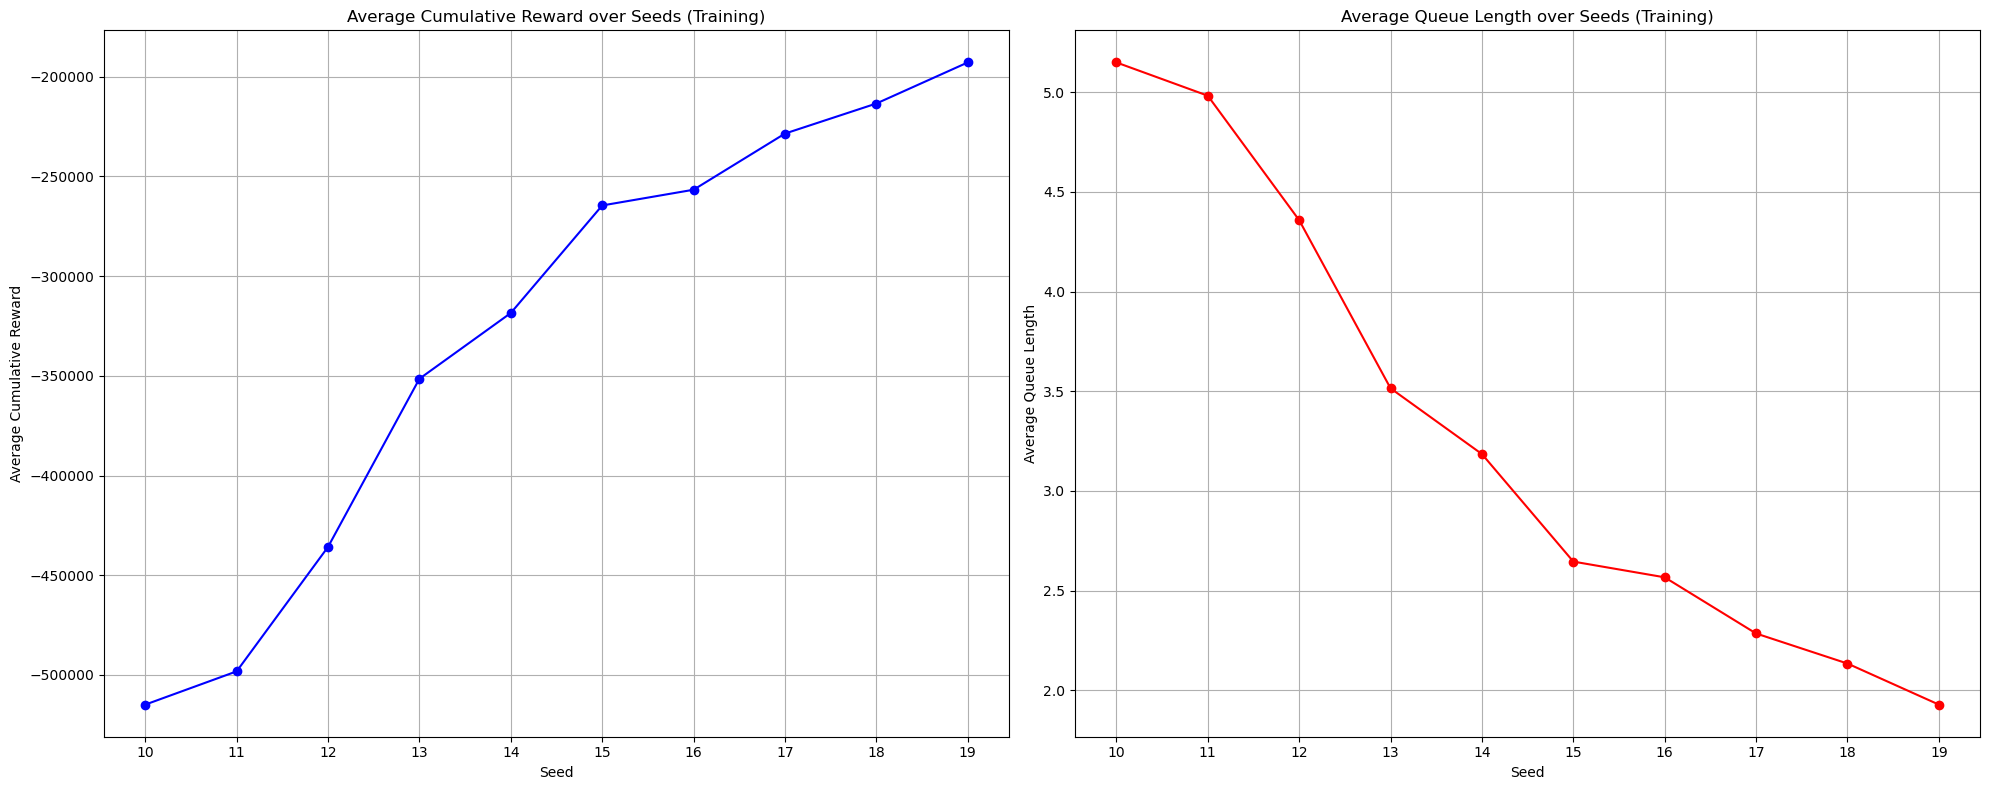

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 8)) 

# Primo subplot: Average Cumulative Reward
axes[0].plot(range(10, 20), average_reward_DQL_training, marker='o', color='blue', label='Average Cumulative Reward')
axes[0].set_title('Average Cumulative Reward over Seeds (Training)')
axes[0].set_xlabel('Seed')
axes[0].set_ylabel('Average Cumulative Reward')
axes[0].set_xticks(range(10, 20))
axes[0].grid(True)

# Secondo subplot: Average Queue Length
axes[1].plot(range(10, 20), average_queue_length_on_seeds_DQL_training, marker='o', color='red', label='Average Queue Length')
axes[1].set_title('Average Queue Length over Seeds (Training)')
axes[1].set_xlabel('Seed')
axes[1].set_ylabel('Average Queue Length')
axes[1].set_xticks(range(10, 20))
axes[1].grid(True)

# Ottimizza layout e salva
plt.tight_layout()
plt.savefig('comparison_over_seeds.png')
plt.show()

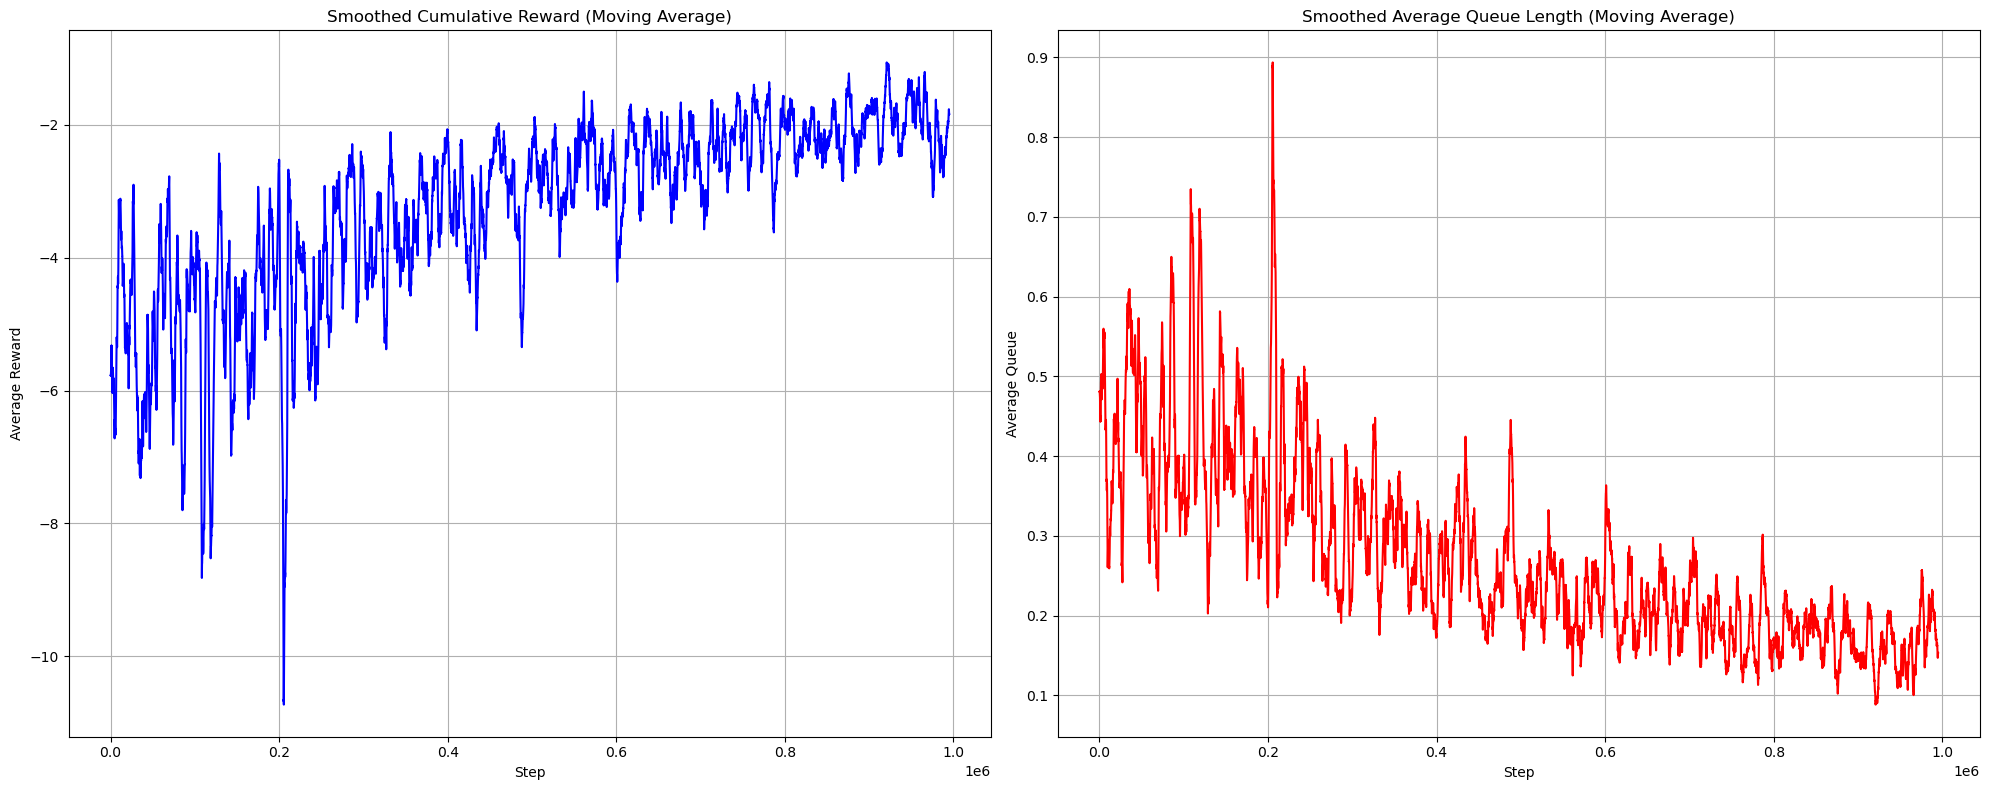

In [33]:
def moving_average(data, window_size=5000):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

ma_rewards = moving_average(all_rewards_DQL_training)
ma_queues = moving_average(all_queues_DQL_training)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Smoothed Reward Plot
axes[0].plot(ma_rewards, color='blue')
axes[0].set_title("Smoothed Cumulative Reward (Moving Average)")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Average Reward")
axes[0].grid(True)

# Smoothed Queue Length Plot
axes[1].plot(ma_queues, color='red')
axes[1].set_title("Smoothed Average Queue Length (Moving Average)")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Average Queue")
axes[1].grid(True)

plt.tight_layout()
plt.savefig("smoothed_metrics_over_all_steps.png")
plt.show()

## Testing

In [17]:
# compile the model
q_net_compiled = torch.compile(q_net)
target_net_compiled = torch.compile(target_net)


In [18]:
EPSILON = 0.0
global_step = 0
average_reward_DQL = []
average_queue_length_on_seeds_DQL = []
all_rewards_DQL = []
all_queues_DQL = []
for seed in range(10,20):
    actions_taken = [0, 0, 0, 0]
    print(f"{Y}Running simulation with seed {seed}{E}")
    Sumo_config = Sumo_init(seed, Visualize=False)
    step_history_DQL, reward_history_DQL, queue_history_DQL, average_queue_length_for_step_history_DQL, cumulative_reward_DQL, average_queue_length_DQL, EPSILON, step_run = run_simulation_DQL(
        20000, detector_ids, traffic_light_id,
        q_net_compiled, target_net_compiled, replay_buf, optimizer,
        EPSILON=EPSILON, training=False, Verbose=True
    )
    average_reward_DQL.append(cumulative_reward_DQL)
    average_queue_length_on_seeds_DQL.append(average_queue_length_DQL)
    all_queues_DQL.extend(average_queue_length_for_step_history_DQL)
    all_rewards_DQL.extend(reward_history_DQL)
    print(f"{Y}Actions taken: {actions_taken}{E}")
    print("-" * 50)

print("Testing complete on", device)
print(f"{Y}Average Cumulative Reward over 10 runs: {np.mean(average_reward_DQL):.2f}, Standard Deviation: {np.std(average_reward_DQL):.2f}{E}")
#compute standard deviation of average reward
print(f"{Y}Average Queue Length over 10 runs: {np.mean(average_queue_length_on_seeds_DQL):.2f}{E}")

Running simulation with seed 10


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -37855.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1), Action: 2
Cumulative Reward: -37855.00, Average Queue Length: 1.89, Epsilon: 0.0000
Actions taken: [7036, 2651, 3769, 1954]
--------------------------------------------------
Running simulation with seed 11


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -45621.00, Queue Lengths: (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), Action: 0
Cumulative Reward: -45621.00, Average Queue Length: 2.28, Epsilon: 0.0000
Actions taken: [8206, 2302, 3512, 1420]
--------------------------------------------------
Running simulation with seed 12


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -40764.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Cumulative Reward: -40764.00, Average Queue Length: 2.04, Epsilon: 0.0000
Actions taken: [7633, 1725, 3660, 2392]
--------------------------------------------------
Running simulation with seed 13


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -39980.00, Queue Lengths: (0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Cumulative Reward: -39980.00, Average Queue Length: 2.00, Epsilon: 0.0000
Actions taken: [7669, 1288, 4127, 2326]
--------------------------------------------------
Running simulation with seed 14


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -45038.00, Queue Lengths: (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), Action: 3
Cumulative Reward: -45038.00, Average Queue Length: 2.25, Epsilon: 0.0000
Actions taken: [7695, 1547, 4335, 1833]
--------------------------------------------------
Running simulation with seed 15


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -42568.00, Queue Lengths: (0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0), Action: 2
Cumulative Reward: -42568.00, Average Queue Length: 2.13, Epsilon: 0.0000
Actions taken: [8658, 1837, 3076, 1839]
--------------------------------------------------
Running simulation with seed 16


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -42124.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0), Action: 2
Cumulative Reward: -42124.00, Average Queue Length: 2.11, Epsilon: 0.0000
Actions taken: [8366, 1857, 3187, 2030]
--------------------------------------------------
Running simulation with seed 17


Cumulative Reward: -40538.00, Average Queue Length: 2.03, Epsilon: 0.0000
Actions taken: [8333, 2016, 3542, 1524]
--------------------------------------------------
Running simulation with seed 18


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -43852.00, Queue Lengths: (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1), Action: 3
Cumulative Reward: -43852.00, Average Queue Length: 2.19, Epsilon: 0.0000
Actions taken: [8049, 1893, 3636, 1832]
--------------------------------------------------
Running simulation with seed 19


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -43679.00, Queue Lengths: (1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), Action: 3
Cumulative Reward: -43679.00, Average Queue Length: 2.18, Epsilon: 0.0000
Actions taken: [7994, 1936, 3925, 1585]
--------------------------------------------------
Testing complete on mps
Average Cumulative Reward over 10 runs: -42201.90, Standard Deviation: 2311.86
Average Queue Length over 10 runs: 2.11


In [20]:
print(f"{Y}Shape of all rewards: {np.shape(all_rewards_DQL)}{E}")

Shape of all rewards: (200005,)


In [21]:
#print shape of all queues
print(f"{Y}Shape of all queues: {np.shape(all_queues_DQL)}{E}")
#print shape step history
print(f"{Y}Shape of step history: {np.shape(step_history_DQL)}{E}")

#print shape of reward history
print(f"{Y}Shape of reward history: {np.shape(reward_history_DQL)}{E}")

#print shape of queue history  
print(f"{Y}Shape of queue history: {np.shape(queue_history_DQL)}{E}")

Shape of all queues: (200005,)
Shape of step history: (20000,)
Shape of reward history: (20000,)
Shape of queue history: (20000, 12)


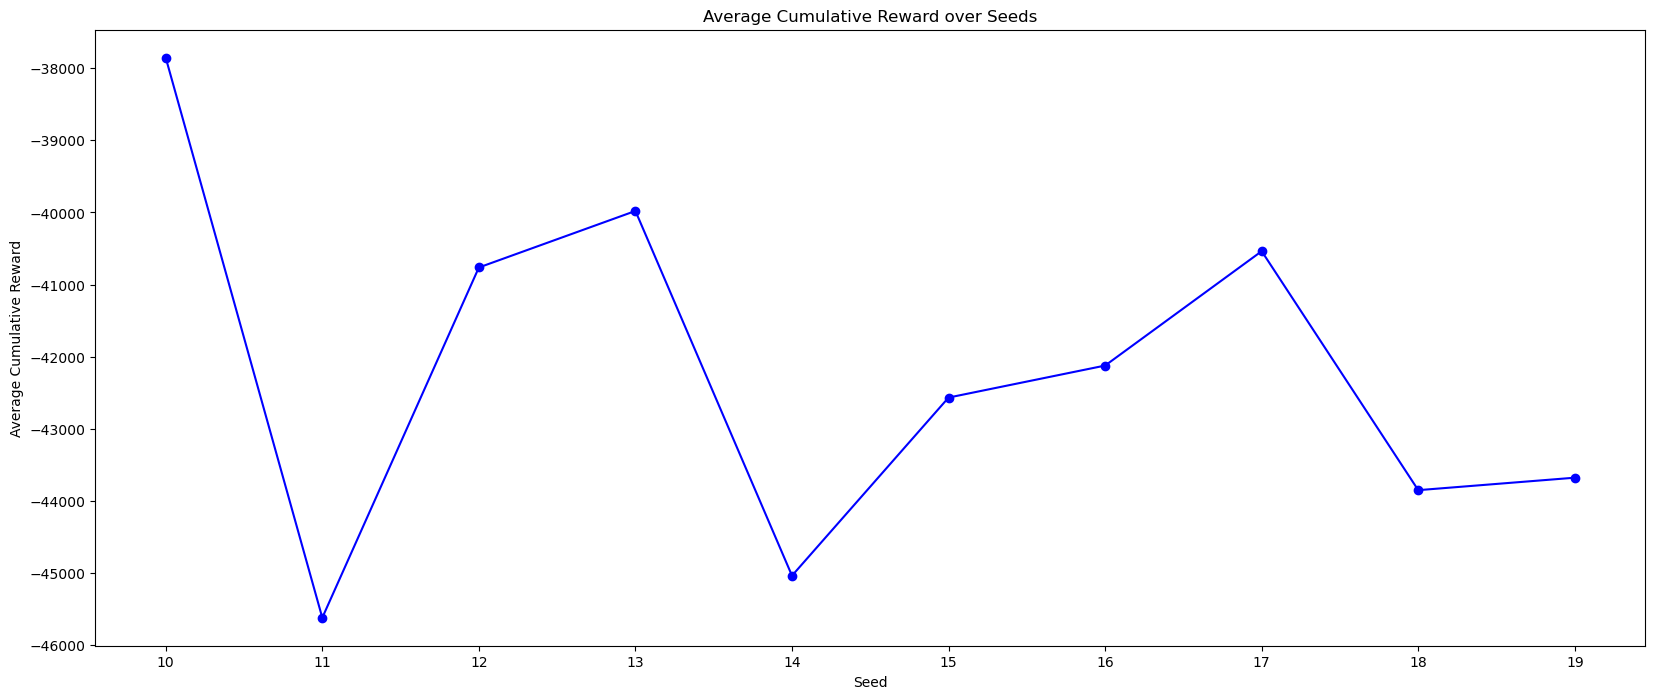

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_reward_DQL, marker='o', color='blue', label='Average Cumulative Reward')
plt.title('Average Cumulative Reward over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Cumulative Reward')
plt.xticks(range(10, 20))

plt.savefig('average_cumulative_reward_over_seeds.png')

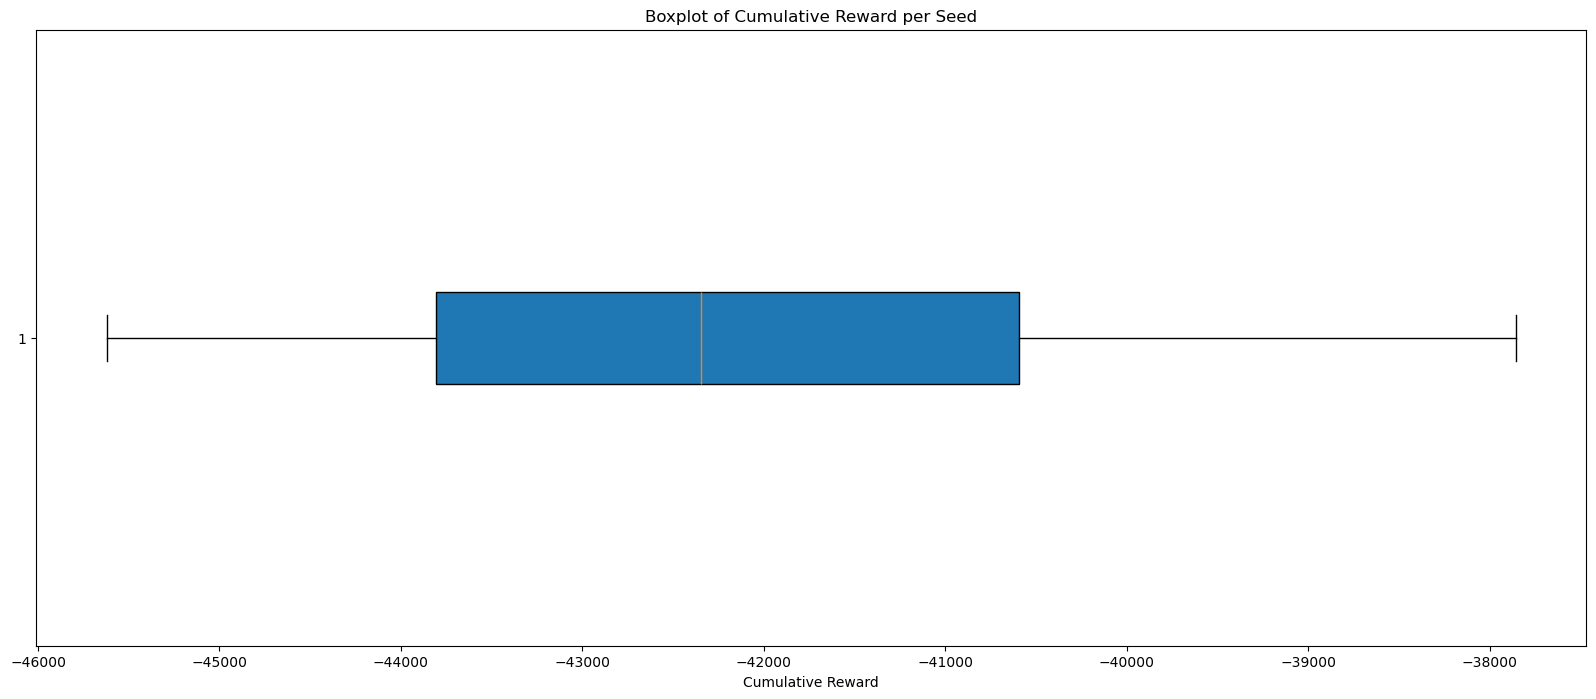

In [23]:
# boxplot cumulative reward per seed
plt.figure(figsize=(20, 8))
plt.boxplot(average_reward_DQL, vert=False, patch_artist=True)
plt.title('Boxplot of Cumulative Reward per Seed')
plt.xlabel('Cumulative Reward')
plt.savefig('boxplot_cumulative_reward_per_seed.png')

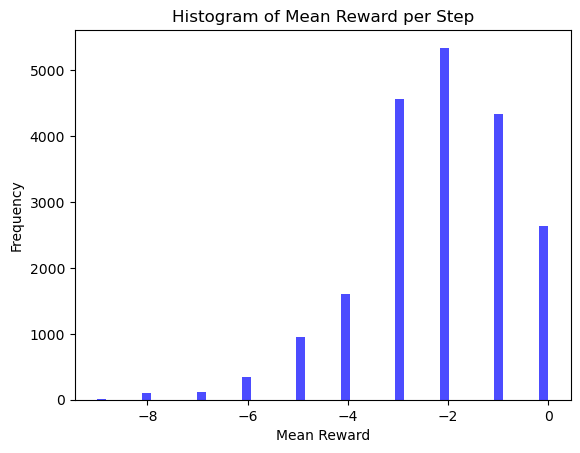

In [24]:
# histogram mean reward per step
plt.hist(reward_history_DQL, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Mean Reward per Step')
plt.xlabel('Mean Reward')
plt.ylabel('Frequency')
plt.savefig('histogram_mean_reward_per_step.png')

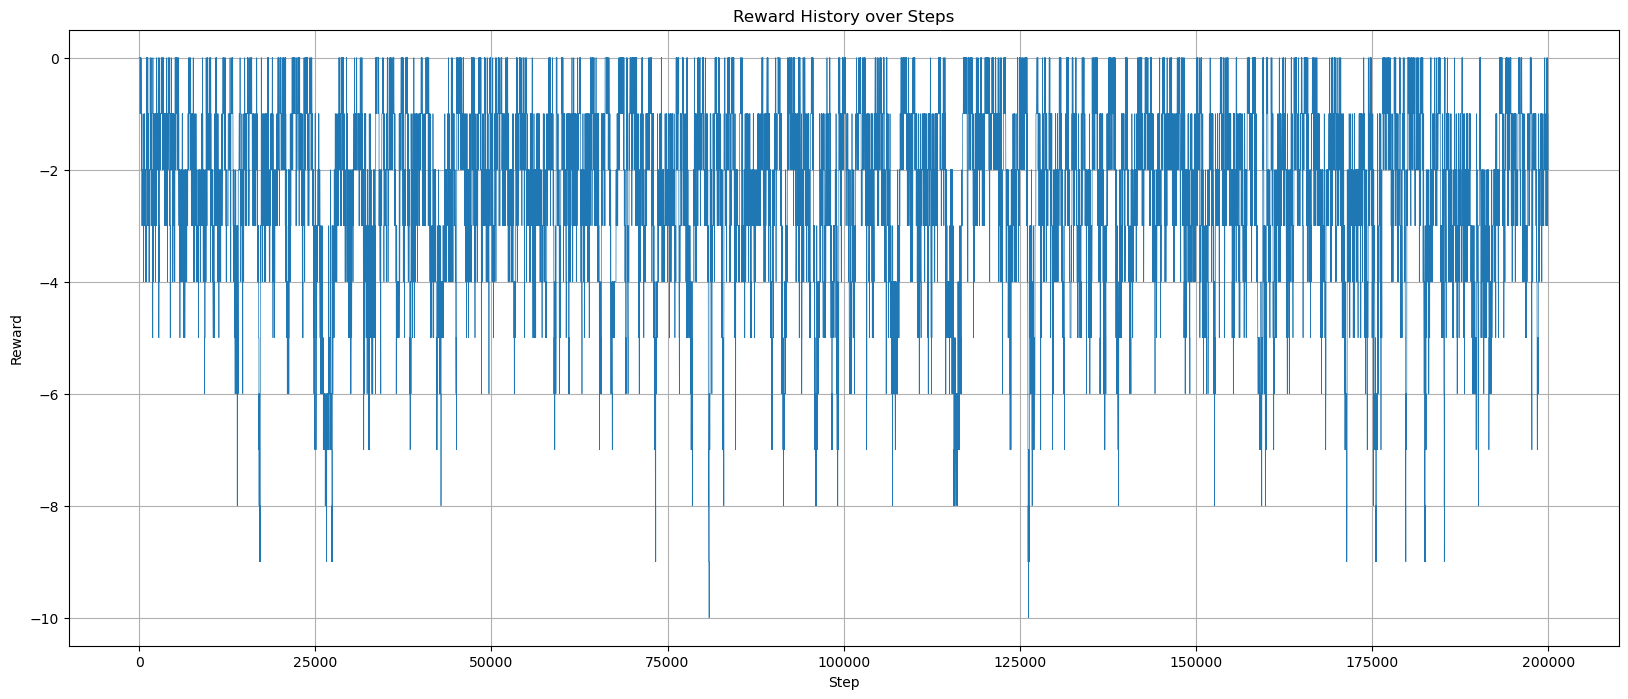

In [25]:
steps = list(range(len(all_rewards_DQL)))
plt.figure(figsize=(20, 8))
plt.plot(steps, all_rewards_DQL, linewidth=0.5)
plt.title('Reward History over Steps')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.grid()
plt.savefig('reward_history_over_steps.png')

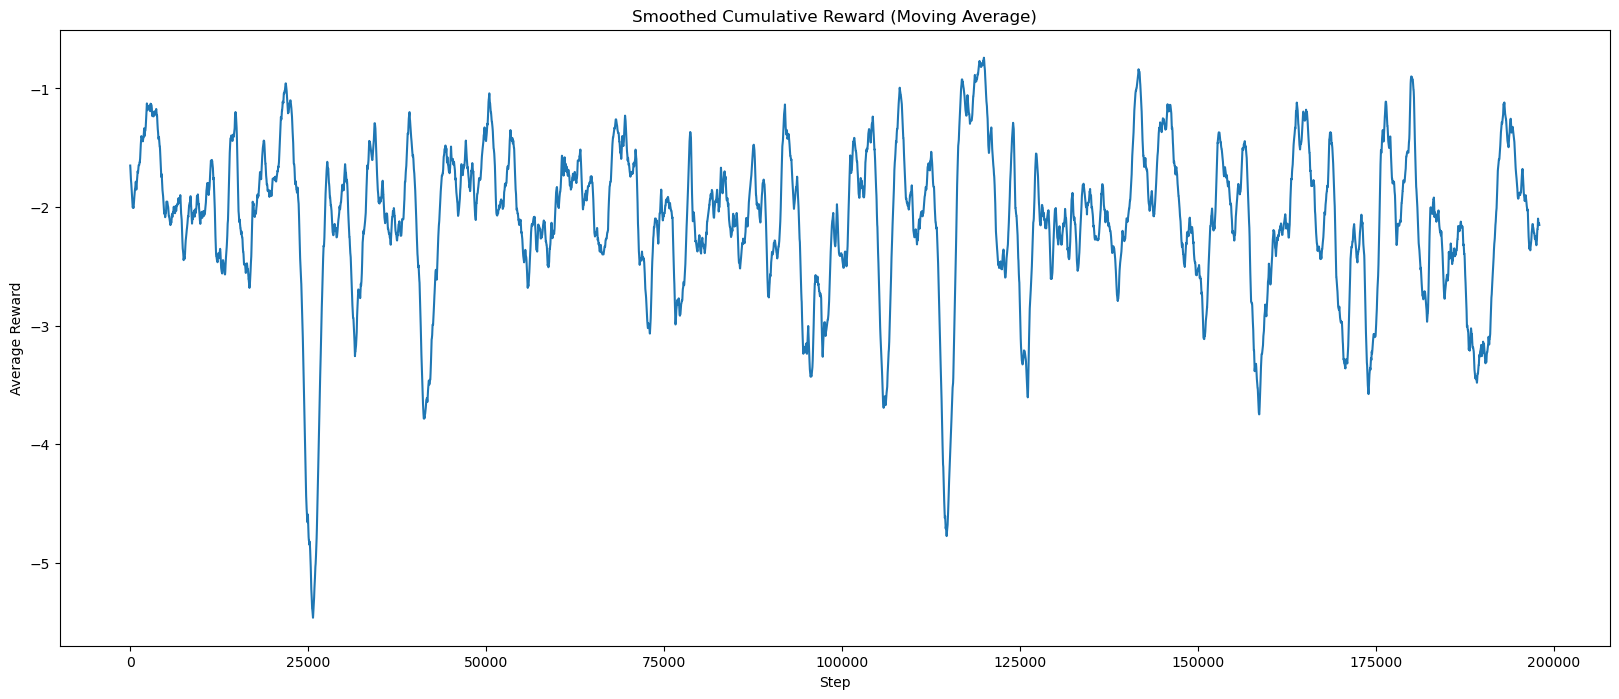

In [26]:
import numpy as np

def moving_average(data, window_size=2000):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

ma_rewards = moving_average(all_rewards_DQL)

plt.figure(figsize=(20, 8))
plt.plot(ma_rewards)
plt.title("Smoothed Cumulative Reward (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.savefig("smoothed_reward_over_all_steps.png")

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_queue_length_on_seeds_DQL, marker='o', color='red', label='Average Queue Length')
plt.title('Average Queue Length over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Queue Length')
plt.xticks(range(10, 20))
plt.savefig('average_queue_length_over_seeds.png')

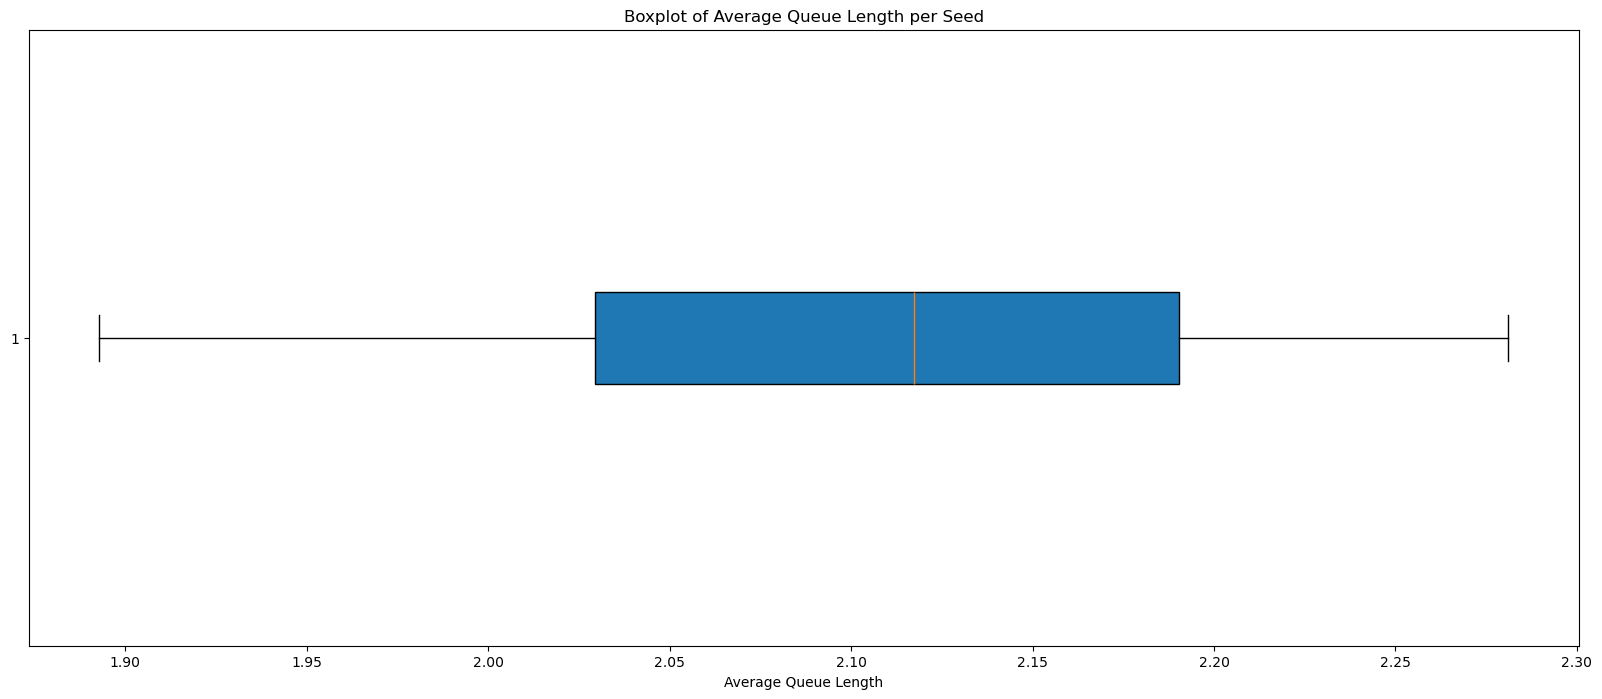

In [28]:
# boxplot average queue length per seed
plt.figure(figsize=(20, 8))
plt.boxplot(average_queue_length_on_seeds_DQL, vert=False, patch_artist=True)
plt.title('Boxplot of Average Queue Length per Seed')
plt.xlabel('Average Queue Length')
plt.savefig('boxplot_average_queue_length_per_seed.png')

In [29]:
steps = list(range(len(all_queues_DQL)))
plt.figure(figsize=(20, 8))
plt.plot(steps, all_queues_DQL, linewidth=0.5)
plt.title('Queue History over Steps')
plt.xlabel('Step')
plt.ylabel('Queue Length')
plt.grid()
plt.savefig('reward_history_over_steps.png')

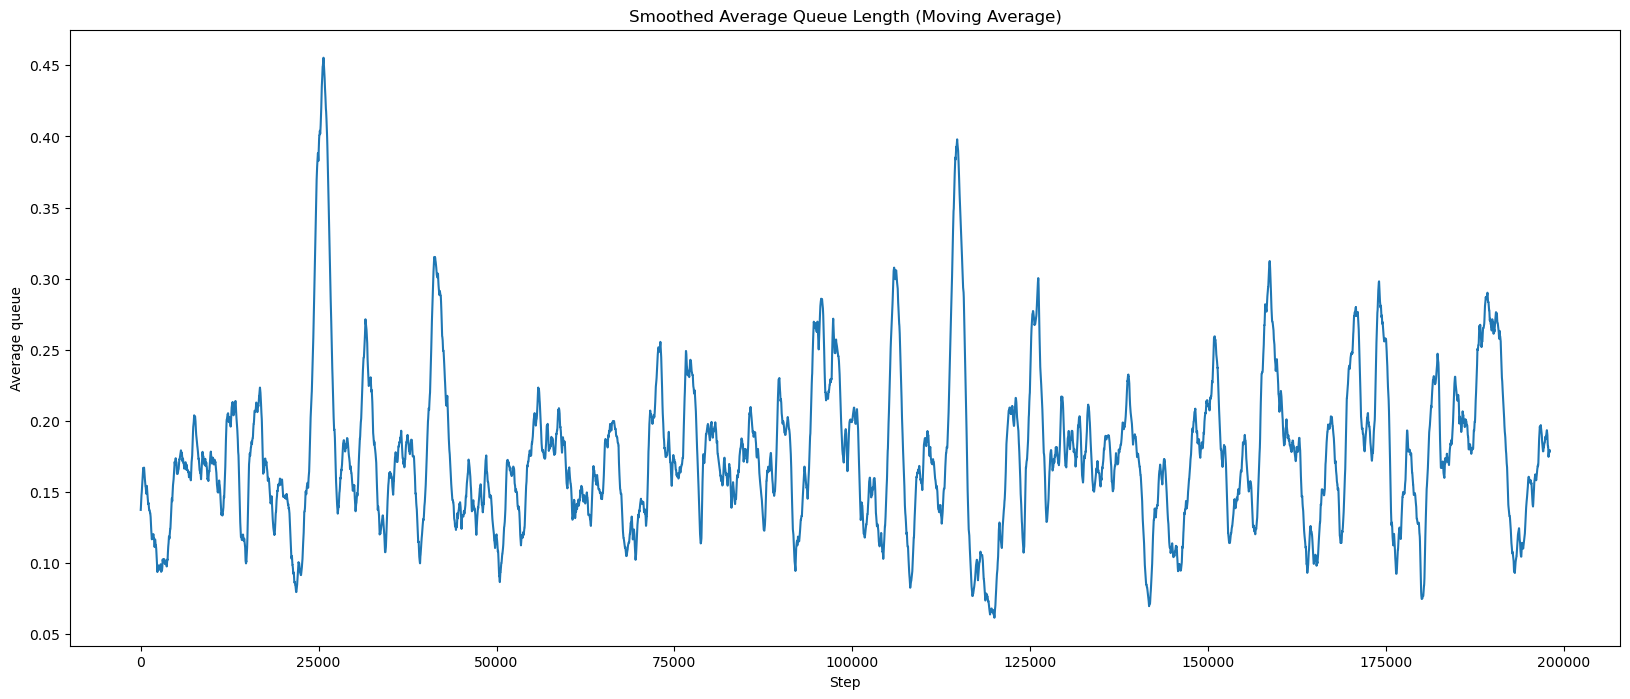

In [30]:
ma_queues = moving_average(all_queues_DQL)

plt.figure(figsize=(20, 8))
plt.plot(ma_queues)
plt.title("Smoothed Average Queue Length (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average queue")
plt.savefig("smoothed_reward_over_all_steps.png")

# Comparisons

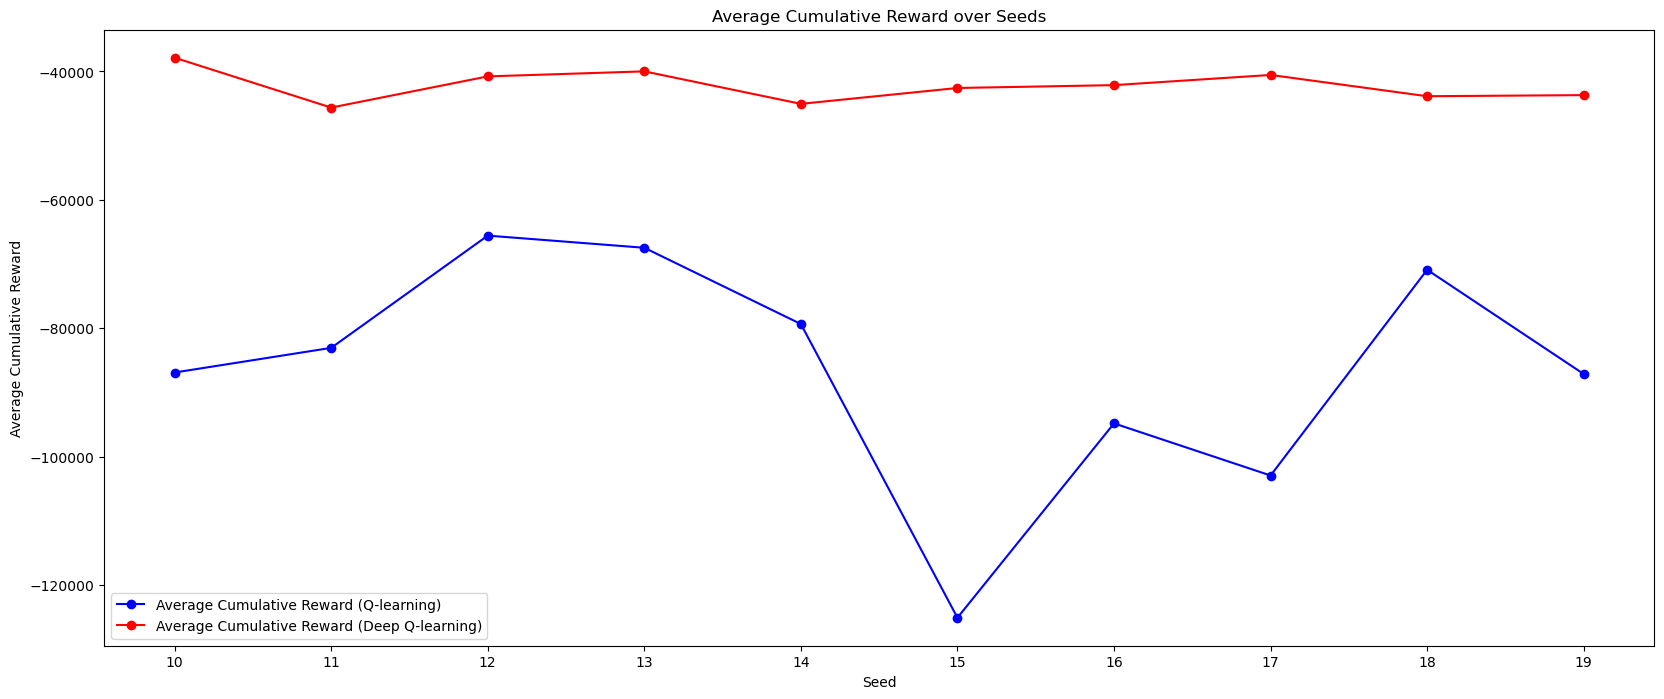

In [58]:
# compare average cumulative reward and average queue length between Q-learning and fixed-time
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_reward_Q, marker='o', color='blue', label='Average Cumulative Reward (Q-learning)')
plt.plot(range(10, 20), average_reward_DQL, marker='o', color='red', label='Average Cumulative Reward (Deep Q-learning)')
plt.title('Average Cumulative Reward over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Cumulative Reward')
plt.xticks(range(10, 20))
plt.legend()
plt.savefig('average_cumulative_reward_comparison.png')

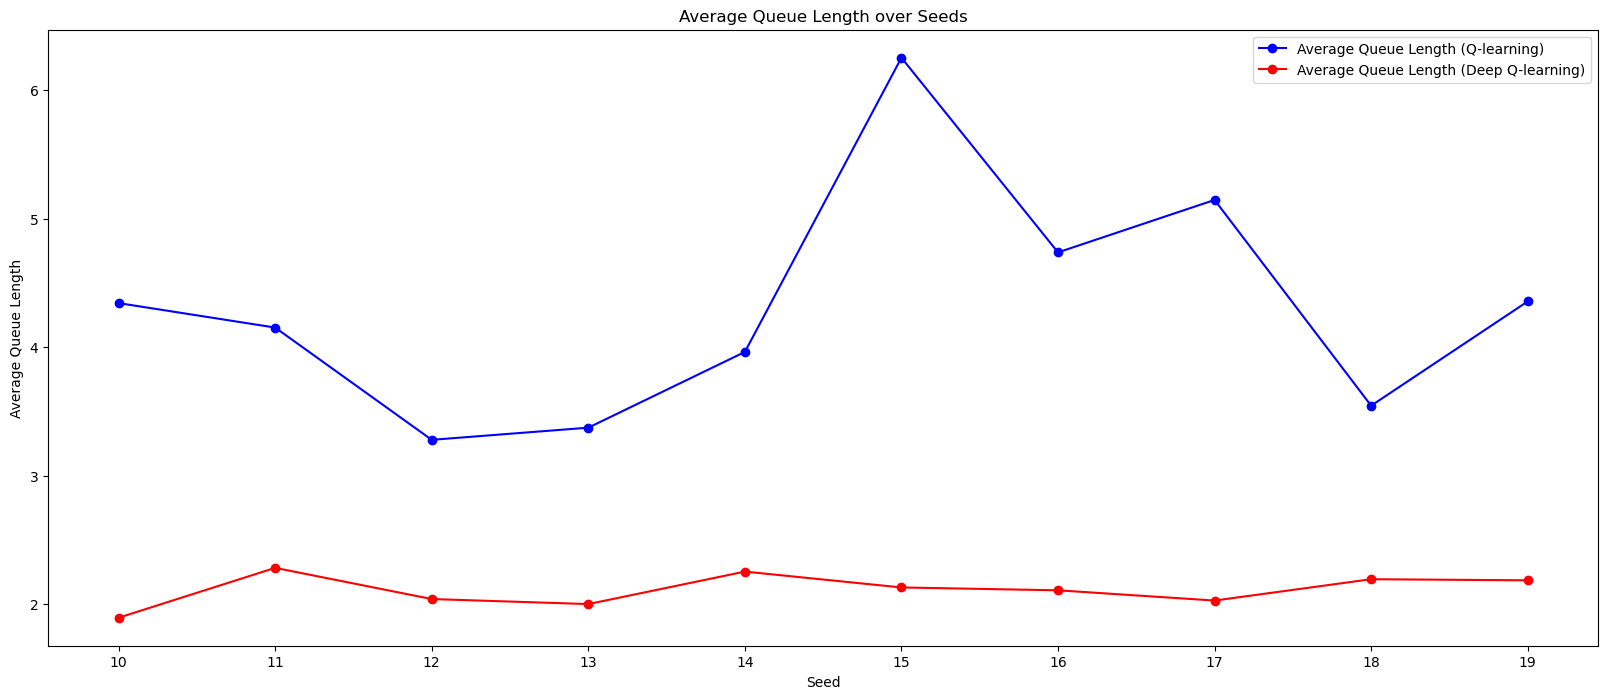

In [67]:
# compare average queue length between Q-learning and fixed-time
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_queue_length_on_seeds_Q, marker='o', color='blue', label='Average Queue Length (Q-learning)')
plt.plot(range(10, 20), average_queue_length_on_seeds_DQL, marker='o', color='red', label='Average Queue Length (Deep Q-learning)')
plt.title('Average Queue Length over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Queue Length')
plt.xticks(range(10, 20))
plt.legend()
plt.savefig('average_queue_length_comparison.png')

/var/folders/62/v47sj7tj04gg3ttc76slz9nr0000gn/T/ipykernel_84071/674058876.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([average_queue_length_on_seeds_Q, average_queue_length_on_seeds_DQL], vert=False, patch_artist=True, labels=['Q-learning', 'Deep Q-learning'])


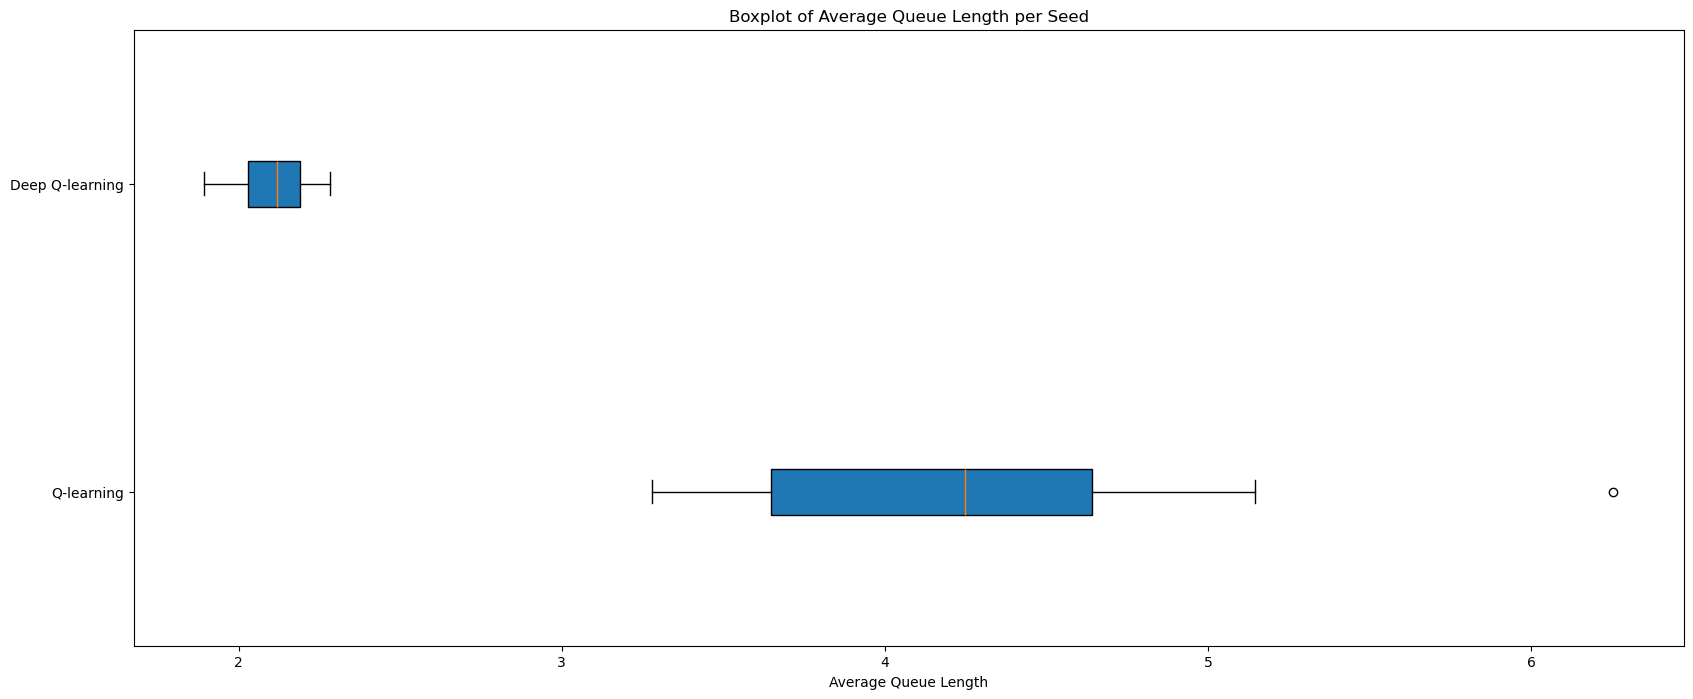

In [60]:
# boxplot average queue length per seed
plt.figure(figsize=(20, 8))
plt.boxplot([average_queue_length_on_seeds_Q, average_queue_length_on_seeds_DQL], vert=False, patch_artist=True, labels=['Q-learning', 'Deep Q-learning'])
plt.title('Boxplot of Average Queue Length per Seed')
plt.xlabel('Average Queue Length')
plt.savefig('boxplot_average_queue_length_comparison.png')

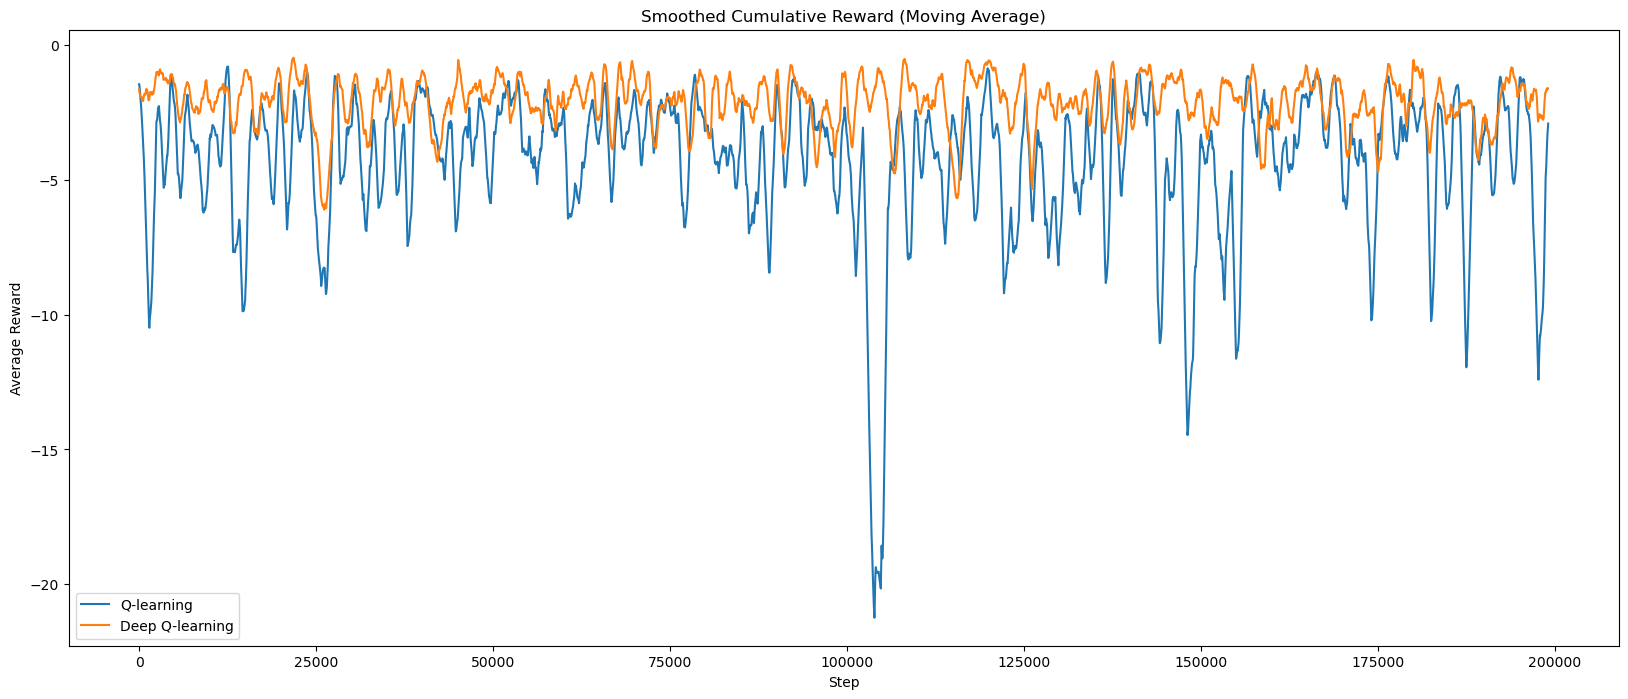

In [61]:
# smoothed reward over all steps
ma_rewards_DQL = moving_average(all_rewards_DQL)
ma_rewards_Q = moving_average(all_rewards_Q)
plt.figure(figsize=(20, 8))
plt.plot(ma_rewards_Q, label='Q-learning')
plt.plot(ma_rewards_DQL, label='Deep Q-learning')
plt.title("Smoothed Cumulative Reward (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.legend()
plt.savefig("smoothed_reward_comparison.png")

In [63]:
# smoothed average queue length over all steps
ma_queues_DQL = moving_average(all_queues_DQL)
ma_queues_Q = moving_average(all_queues_Q)
plt.figure(figsize=(20, 8))
plt.plot(ma_queues_DQL, label='Deep Q-learning')
plt.plot(ma_queues_Q, label='Q-learning')
plt.title("Smoothed Average Queue Length (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average queue")
plt.legend()
plt.savefig("smoothed_queue_comparison.png")

# Extra

In [177]:
EPSILON = 1.0
global_step = 0
average_reward_DQL = []
average_queue_length_on_seeds_DQL = []
all_rewards_DQL = []
all_queues_DQL = []
for seed in range(10):
    print(f"{Y}Running simulation with seed {seed}{E}")
    actions_taken = [0, 0, 0, 0]
    Sumo_config = Sumo_init(seed, Visualize=False)
    #keep epsilon 1 for the firsts two seed
    step_history, reward_history, queue_history, average_queue_length_for_step_history, cumulative_reward, average_queue_length, EPSILON, step_run = run_simulation_DQL_pytorch(
        100000, detector_ids, traffic_light_id,
        q_net, target_net, replay_buf, optimizer,
        EPSILON = EPSILON, training=True, Verbose=True, global_step=global_step,
    )
    global_step += step_run
    all_queues_DQL.extend(average_queue_length_for_step_history)
    all_rewards_DQL.extend(reward_history)
    print(f"{Y}Actions taken: {actions_taken}{'#888822'}")
    print("-" * 50)


print("Training complete on", device)

Running simulation with seed 0


Step 20000/100000, Epsilon: 0.9990, Cumulative Reward: -90768.00, Queue Lengths: (0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0), Action: 1
Step 40000/100000, Epsilon: 0.9961, Cumulative Reward: -178786.00, Queue Lengths: (0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0), Action: 3
Step 100000/100000, Epsilon: 0.9758, Cumulative Reward: -510325.00, Queue Lengths: (0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0), Action: 2
Cumulative Reward: -510325.00, Average Queue Length: 4.90, Epsilon: 0.9758
Actions taken: [73, 6, 41, 517]#888822
--------------------------------------------------
Running simulation with seed 1


Step 20000/100000, Epsilon: 0.9652, Cumulative Reward: -88019.00, Queue Lengths: (0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1), Action: 0
Step 40000/100000, Epsilon: 0.9529, Cumulative Reward: -174191.00, Queue Lengths: (2, 1, 3, 0, 0, 0, 1, 1, 1, 0, 0, 0), Action: 0
Step 80000/100000, Epsilon: 0.9229, Cumulative Reward: -389100.00, Queue Lengths: (0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0), Action: 2
Step 100000/100000, Epsilon: 0.9055, Cumulative Reward: -479794.00, Queue Lengths: (1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0), Action: 2
Cumulative Reward: -479794.00, Average Queue Length: 4.59, Epsilon: 0.9055
Actions taken: [456, 180, 401, 3171]#888822
--------------------------------------------------
Running simulation with seed 2


Step 20000/100000, Epsilon: 0.8864, Cumulative Reward: -84629.00, Queue Lengths: (1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0), Action: 3
Step 60000/100000, Epsilon: 0.8439, Cumulative Reward: -230858.00, Queue Lengths: (0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0), Action: 0
Step 80000/100000, Epsilon: 0.8205, Cumulative Reward: -303893.00, Queue Lengths: (0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0), Action: 0
Cumulative Reward: -368835.00, Average Queue Length: 3.48, Epsilon: 0.7959
Actions taken: [5492, 753, 4204, 953]#888822
--------------------------------------------------
Running simulation with seed 3


Step 20000/100000, Epsilon: 0.7702, Cumulative Reward: -63035.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0), Action: 0
Step 40000/100000, Epsilon: 0.7435, Cumulative Reward: -123800.00, Queue Lengths: (0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0), Action: 2
Step 80000/100000, Epsilon: 0.6872, Cumulative Reward: -257314.00, Queue Lengths: (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1), Action: 3
Cumulative Reward: -329172.00, Average Queue Length: 3.09, Epsilon: 0.6579
Actions taken: [8752, 1907, 7593, 2495]#888822
--------------------------------------------------
Running simulation with seed 4


Step 20000/100000, Epsilon: 0.6281, Cumulative Reward: -75915.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Step 60000/100000, Epsilon: 0.5670, Cumulative Reward: -207189.00, Queue Lengths: (0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0), Action: 2
Step 80000/100000, Epsilon: 0.5360, Cumulative Reward: -256887.00, Queue Lengths: (1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0), Action: 0
Step 100000/100000, Epsilon: 0.5050, Cumulative Reward: -317680.00, Queue Lengths: (0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0), Action: 2
Cumulative Reward: -317680.00, Average Queue Length: 2.97, Epsilon: 0.5050
Actions taken: [11966, 3728, 12031, 4311]#888822
--------------------------------------------------
Running simulation with seed 5


Step 20000/100000, Epsilon: 0.4739, Cumulative Reward: -58878.00, Queue Lengths: (0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), Action: 0
Step 40000/100000, Epsilon: 0.4429, Cumulative Reward: -112232.00, Queue Lengths: (1, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0), Action: 2
Step 60000/100000, Epsilon: 0.4122, Cumulative Reward: -163989.00, Queue Lengths: (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Step 80000/100000, Epsilon: 0.3819, Cumulative Reward: -207782.00, Queue Lengths: (1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2), Action: 3
Step 100000/100000, Epsilon: 0.3520, Cumulative Reward: -262094.00, Queue Lengths: (0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 2
Cumulative Reward: -262094.00, Average Queue Length: 2.42, Epsilon: 0.3520
Actions taken: [16733, 5354, 15972, 6352]#888822
--------------------------------------------------
Running simulation with seed 6


Step 20000/100000, Epsilon: 0.3227, Cumulative Reward: -49551.00, Queue Lengths: (0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1), Action: 3
Step 60000/100000, Epsilon: 0.2665, Cumulative Reward: -153190.00, Queue Lengths: (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), Action: 3
Step 100000/100000, Epsilon: 0.2140, Cumulative Reward: -254767.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0), Action: 2
Cumulative Reward: -254767.00, Average Queue Length: 2.34, Epsilon: 0.2140
Actions taken: [20641, 7071, 18788, 8865]#888822
--------------------------------------------------
Running simulation with seed 7


Step 20000/100000, Epsilon: 0.1894, Cumulative Reward: -59619.00, Queue Lengths: (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Step 40000/100000, Epsilon: 0.1661, Cumulative Reward: -107151.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Step 60000/100000, Epsilon: 0.1441, Cumulative Reward: -150646.00, Queue Lengths: (0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0), Action: 0
Step 80000/100000, Epsilon: 0.1236, Cumulative Reward: -191347.00, Queue Lengths: (0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0), Action: 2
Cumulative Reward: -239224.00, Average Queue Length: 2.18, Epsilon: 0.1045
Actions taken: [24204, 8649, 22678, 9713]#888822
--------------------------------------------------
Running simulation with seed 8


Step 20000/100000, Epsilon: 0.0870, Cumulative Reward: -44042.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Step 60000/100000, Epsilon: 0.0571, Cumulative Reward: -127025.00, Queue Lengths: (0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1), Action: 0
Step 80000/100000, Epsilon: 0.0447, Cumulative Reward: -169364.00, Queue Lengths: (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0), Action: 2
Step 100000/100000, Epsilon: 0.0342, Cumulative Reward: -207351.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Cumulative Reward: -207351.00, Average Queue Length: 1.87, Epsilon: 0.0342
Actions taken: [27963, 11439, 22683, 10008]#888822
--------------------------------------------------
Running simulation with seed 9


Step 20000/100000, Epsilon: 0.0255, Cumulative Reward: -37580.00, Queue Lengths: (1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0), Action: 0
Step 40000/100000, Epsilon: 0.0188, Cumulative Reward: -75231.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Step 80000/100000, Epsilon: 0.0110, Cumulative Reward: -143758.00, Queue Lengths: (0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1), Action: 2
Step 100000/100000, Epsilon: 0.0100, Cumulative Reward: -188371.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Cumulative Reward: -188371.00, Average Queue Length: 1.69, Epsilon: 0.0100
Actions taken: [24187, 12020, 28600, 11117]#888822
--------------------------------------------------
Training complete on mps


In [178]:
# save the model
torch.save(q_net.state_dict(), "dqn_model.pth")
torch.save(target_net.state_dict(), "dqn_target_model.pth")

In [179]:
# compile the model
q_net_compiled = torch.compile(q_net)
target_net_compiled = torch.compile(target_net)

torch.save(q_net_compiled.state_dict(), "dqn_model_compiled.pth")
torch.save(target_net_compiled.state_dict(), "dqn_target_model_compiled.pth")

In [188]:
EPSILON = 0.0
global_step = 0
average_reward_DQL = []
average_queue_length_on_seeds_DQL = []
all_rewards_DQL = []
all_queues_DQL = []
for seed in range(10,20):
    actions_taken = [0, 0, 0, 0]
    print(f"{Y}Running simulation with seed {seed}{E}")
    Sumo_config = Sumo_init(seed, Visualize=False)
    step_history_DQL, reward_history_DQL, queue_history_DQL, average_queue_length_for_step_history_DQL, cumulative_reward_DQL, average_queue_length_DQL, EPSILON, step_run = run_simulation_DQL_pytorch(
        20000, detector_ids, traffic_light_id,
        q_net_compiled, target_net_compiled, replay_buf, optimizer,
        EPSILON=EPSILON, training=False, Verbose=True
    )
    average_reward_DQL.append(cumulative_reward_DQL)
    average_queue_length_on_seeds_DQL.append(average_queue_length_DQL)
    all_queues_DQL.extend(average_queue_length_for_step_history_DQL)
    all_rewards_DQL.extend(reward_history_DQL)
    print(f"{Y}Actions taken: {actions_taken}{E}")
    print("-" * 50)

print("Testing complete on", device)
print(f"{Y}Average Cumulative Reward over 10 runs: {np.mean(average_reward_DQL):.2f}, Standard Deviation: {np.std(average_reward_DQL):.2f}{E}")
#compute standard deviation of average reward
print(f"{Y}Average Queue Length over 10 runs: {np.mean(average_queue_length_on_seeds_DQL):.2f}{E}")

Running simulation with seed 10


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -50667.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1), Action: 3
Cumulative Reward: -50667.00, Average Queue Length: 2.36, Epsilon: 0.0000
Actions taken: [7300, 2499, 3506, 2135]
--------------------------------------------------
Running simulation with seed 11


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -41004.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 3
Cumulative Reward: -41004.00, Average Queue Length: 1.86, Epsilon: 0.0000
Actions taken: [8755, 2126, 3437, 1122]
--------------------------------------------------
Running simulation with seed 12


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -47603.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2), Action: 3
Cumulative Reward: -47603.00, Average Queue Length: 2.20, Epsilon: 0.0000
Actions taken: [7973, 1662, 3128, 2677]
--------------------------------------------------
Running simulation with seed 13


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -53062.00, Queue Lengths: (0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 1
Cumulative Reward: -53062.00, Average Queue Length: 2.49, Epsilon: 0.0000
Actions taken: [7694, 1938, 3534, 2274]
--------------------------------------------------
Running simulation with seed 14


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -50917.00, Queue Lengths: (0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0), Action: 3
Cumulative Reward: -50917.00, Average Queue Length: 2.37, Epsilon: 0.0000
Actions taken: [8122, 1870, 3606, 1842]
--------------------------------------------------
Running simulation with seed 15


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -41453.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Cumulative Reward: -41453.00, Average Queue Length: 1.89, Epsilon: 0.0000
Actions taken: [8511, 2282, 3061, 1586]
--------------------------------------------------
Running simulation with seed 16


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -50207.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0), Action: 2
Cumulative Reward: -50207.00, Average Queue Length: 2.31, Epsilon: 0.0000
Actions taken: [7997, 2032, 3287, 2124]
--------------------------------------------------
Running simulation with seed 17


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -43585.00, Queue Lengths: (0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2), Action: 2
Cumulative Reward: -43585.00, Average Queue Length: 2.00, Epsilon: 0.0000
Actions taken: [8209, 2297, 3608, 1326]
--------------------------------------------------
Running simulation with seed 18


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -53408.00, Queue Lengths: (0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0), Action: 1
Cumulative Reward: -53408.00, Average Queue Length: 2.46, Epsilon: 0.0000
Actions taken: [8017, 1968, 3272, 2183]
--------------------------------------------------
Running simulation with seed 19


Step 20000/20000, Epsilon: 0.0000, Cumulative Reward: -49847.00, Queue Lengths: (1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), Action: 0
Cumulative Reward: -49847.00, Average Queue Length: 2.30, Epsilon: 0.0000
Actions taken: [7804, 2017, 3370, 2249]
--------------------------------------------------
Testing complete on mps
Average Cumulative Reward over 10 runs: -48175.30, Standard Deviation: 4358.03
Average Queue Length over 10 runs: 2.22


In [190]:
print(f"{Y}Shape of all rewards: {np.shape(all_rewards_DQL)}{E}")

Shape of all rewards: (200000,)


In [192]:
#print shape of all queues
print(f"{Y}Shape of all queues: {np.shape(all_queues_DQL)}{E}")
#print shape step history
print(f"{Y}Shape of step history: {np.shape(step_history_DQL)}{E}")

#print shape of reward history
print(f"{Y}Shape of reward history: {np.shape(reward_history_DQL)}{E}")

#print shape of queue history  
print(f"{Y}Shape of queue history: {np.shape(queue_history_DQL)}{E}")

Shape of all queues: (154400,)
Shape of step history: (15440,)
Shape of reward history: (20000,)
Shape of queue history: (15440, 12)


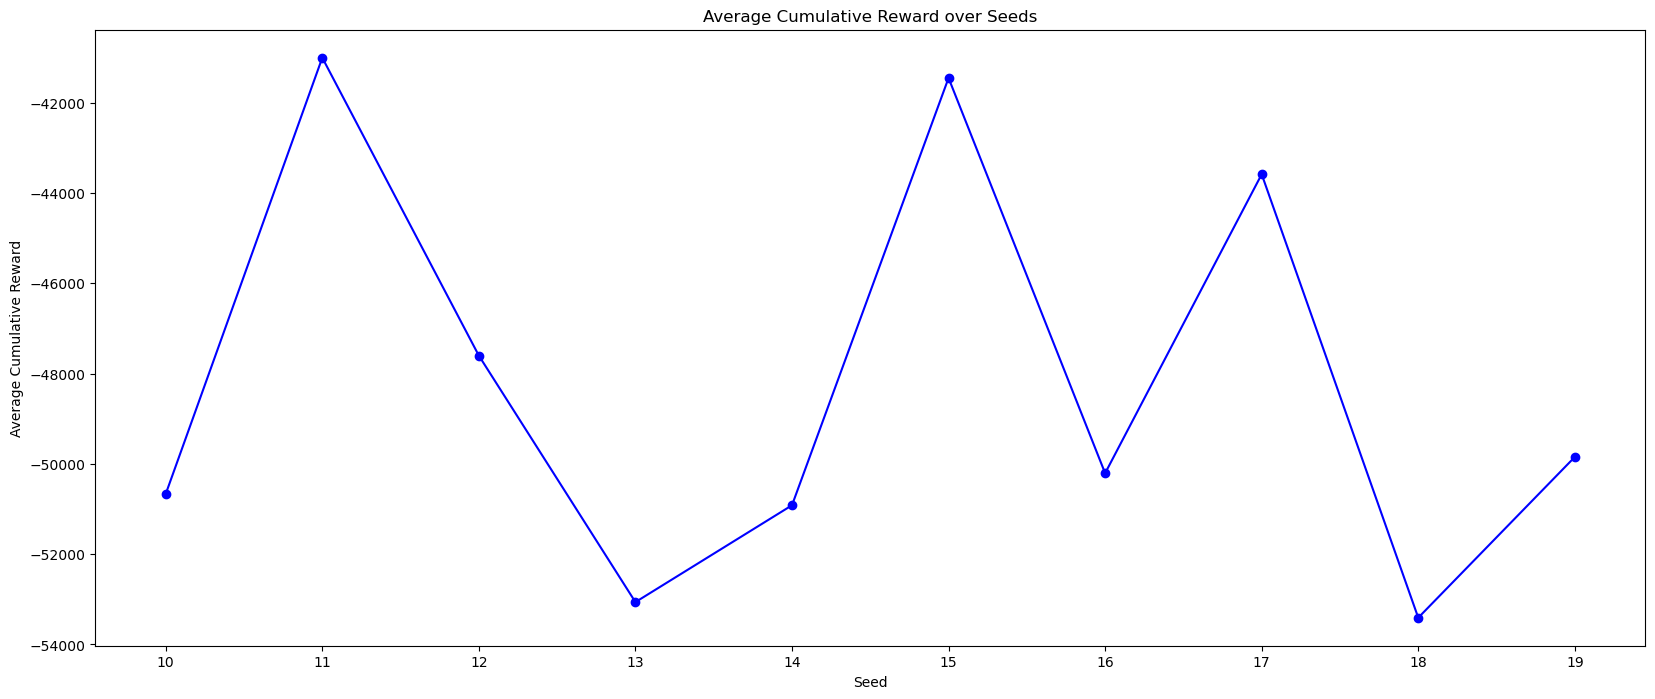

In [193]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_reward_DQL, marker='o', color='blue', label='Average Cumulative Reward')
plt.title('Average Cumulative Reward over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Cumulative Reward')
plt.xticks(range(10, 20))

plt.savefig('average_cumulative_reward_over_seeds.png')

In [194]:
# boxplot cumulative reward per seed
plt.figure(figsize=(20, 8))
plt.boxplot(average_reward_DQL, vert=False, patch_artist=True)
plt.title('Boxplot of Cumulative Reward per Seed')
plt.xlabel('Cumulative Reward')
plt.savefig('boxplot_cumulative_reward_per_seed.png')

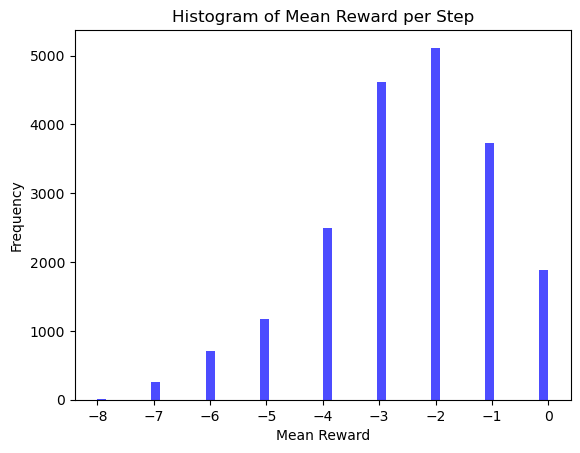

In [202]:
# histogram mean reward per step
plt.hist(reward_history_DQL, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Mean Reward per Step')
plt.xlabel('Mean Reward')
plt.ylabel('Frequency')
plt.savefig('histogram_mean_reward_per_step.png')

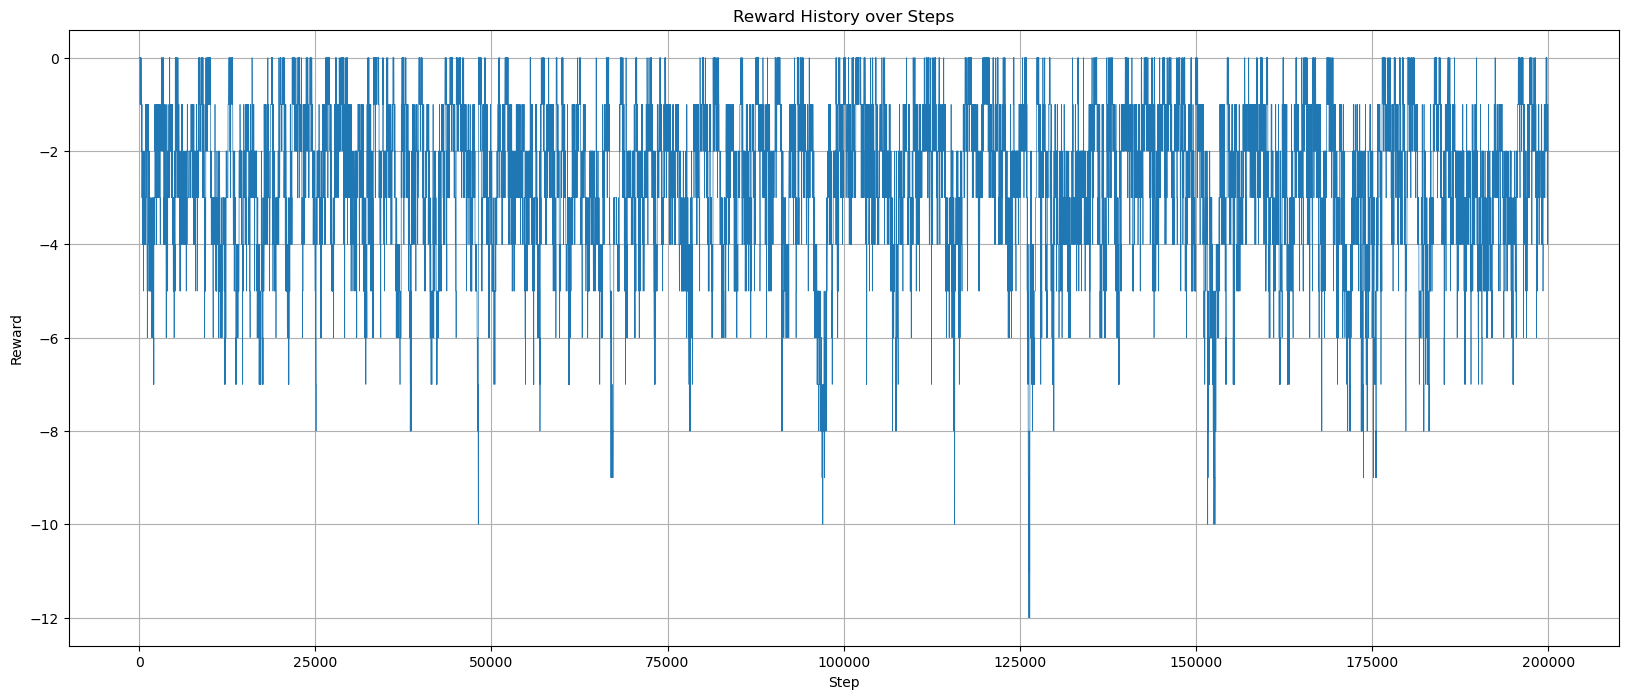

In [203]:
steps = list(range(len(all_rewards_DQL)))
plt.figure(figsize=(20, 8))
plt.plot(steps, all_rewards_DQL, linewidth=0.5)
plt.title('Reward History over Steps')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.grid()
plt.savefig('reward_history_over_steps.png')

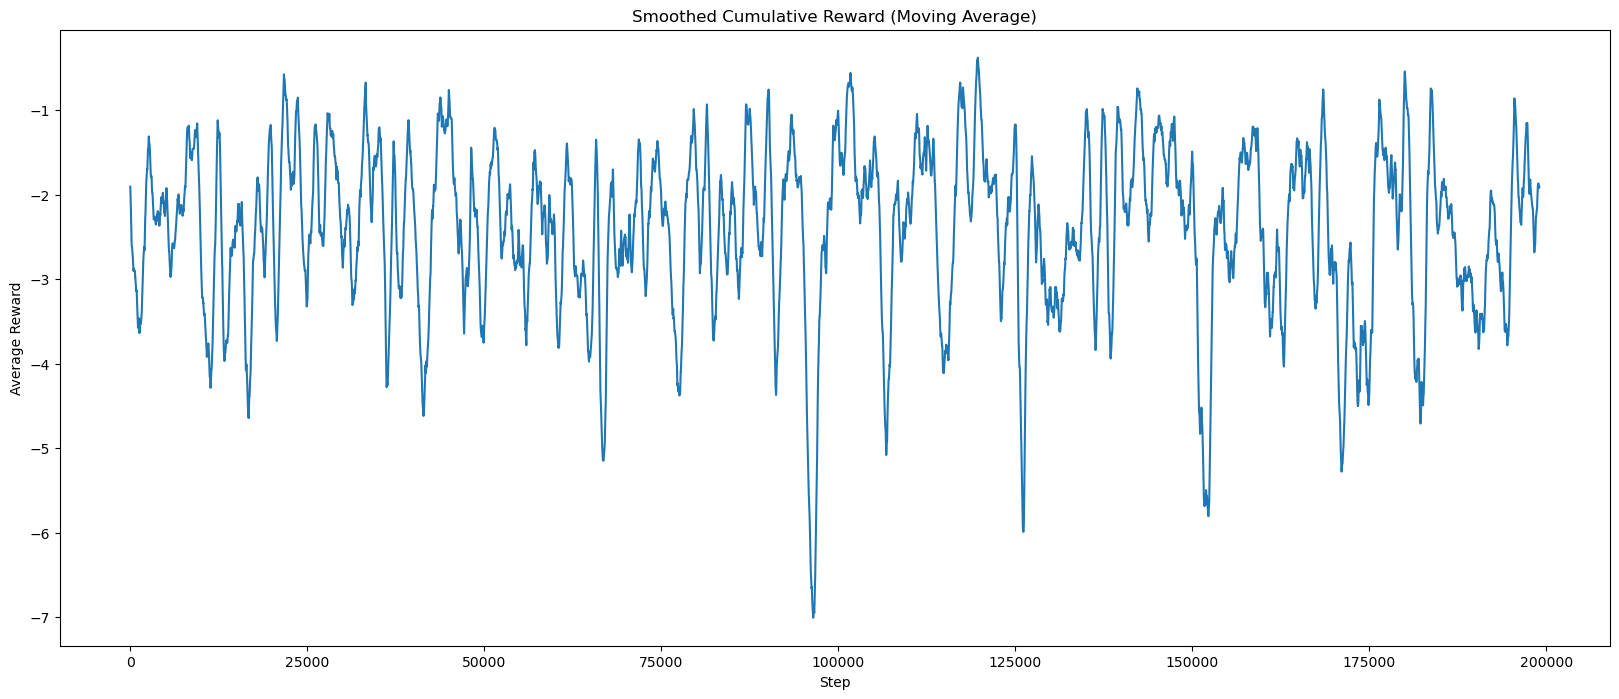

In [205]:
import numpy as np

def moving_average(data, window_size=1000):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

ma_rewards = moving_average(all_rewards_DQL)

plt.figure(figsize=(20, 8))
plt.plot(ma_rewards)
plt.title("Smoothed Cumulative Reward (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.savefig("smoothed_reward_over_all_steps.png")

In [207]:
plt.figure(figsize=(20, 8))
plt.plot(range(10, 20), average_queue_length_on_seeds_DQL, marker='o', color='red', label='Average Queue Length')
plt.title('Average Queue Length over Seeds')
plt.xlabel('Seed')
plt.ylabel('Average Queue Length')
plt.xticks(range(10, 20))
plt.savefig('average_queue_length_over_seeds.png')

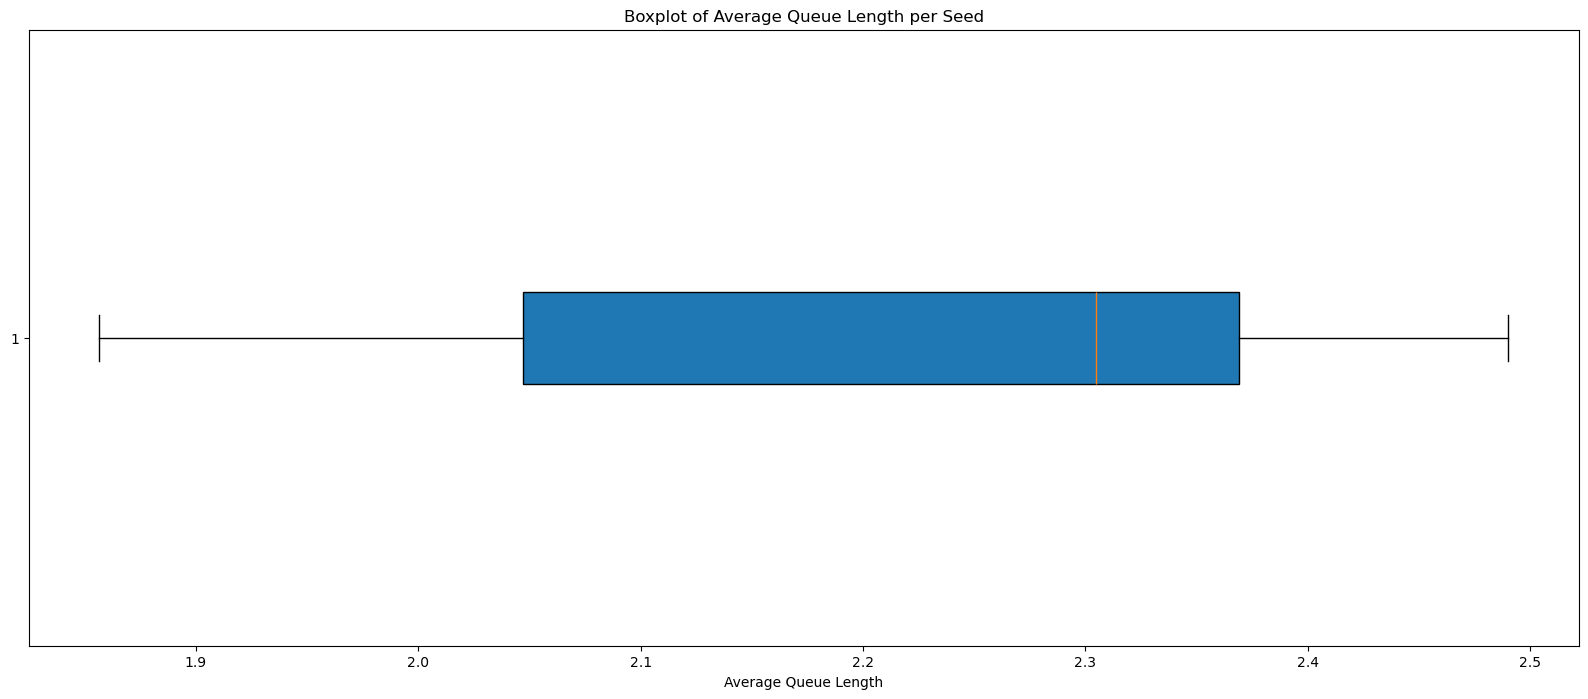

In [208]:
# boxplot average queue length per seed
plt.figure(figsize=(20, 8))
plt.boxplot(average_queue_length_on_seeds_DQL, vert=False, patch_artist=True)
plt.title('Boxplot of Average Queue Length per Seed')
plt.xlabel('Average Queue Length')
plt.savefig('boxplot_average_queue_length_per_seed.png')

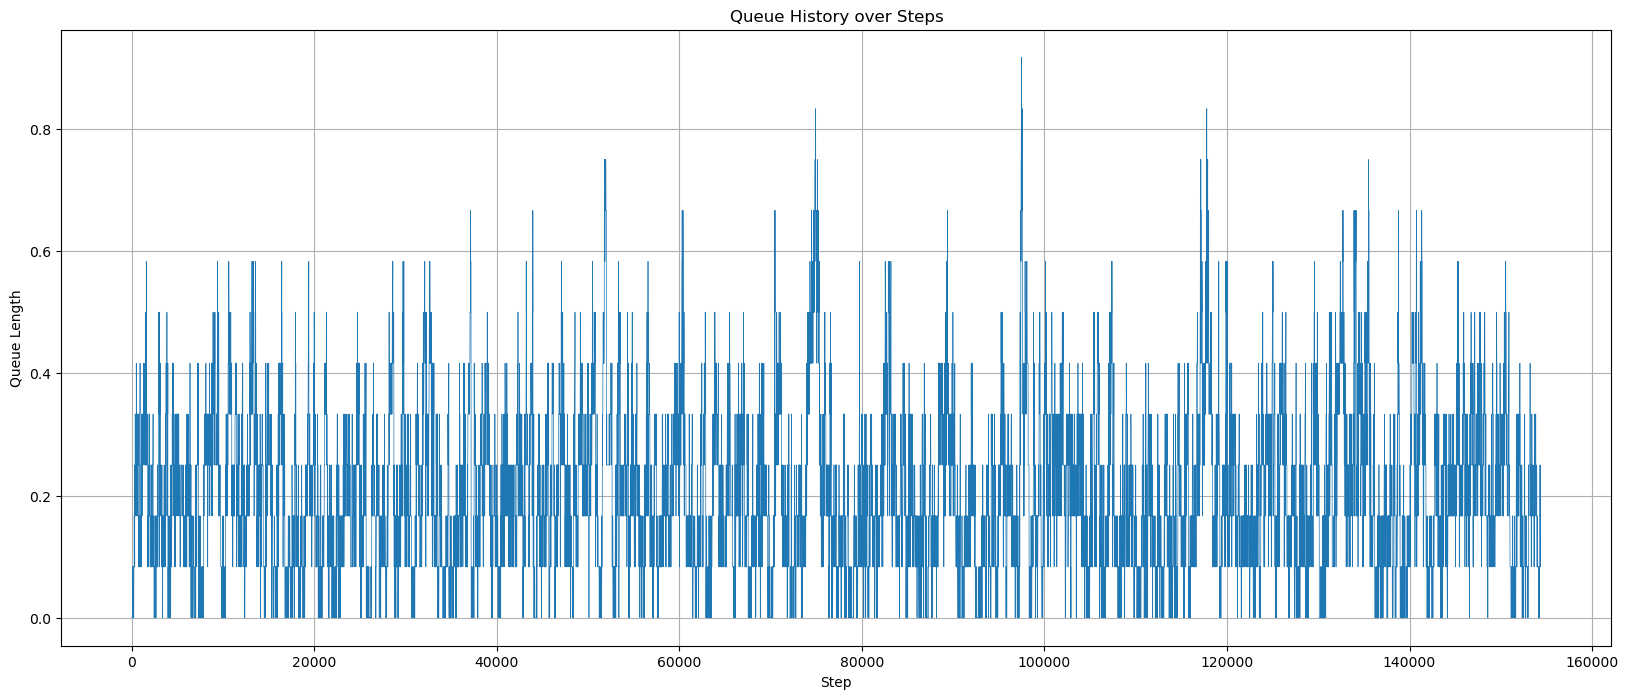

In [209]:
steps = list(range(len(all_queues_DQL)))
plt.figure(figsize=(20, 8))
plt.plot(steps, all_queues_DQL, linewidth=0.5)
plt.title('Queue History over Steps')
plt.xlabel('Step')
plt.ylabel('Queue Length')
plt.grid()
plt.savefig('reward_history_over_steps.png')

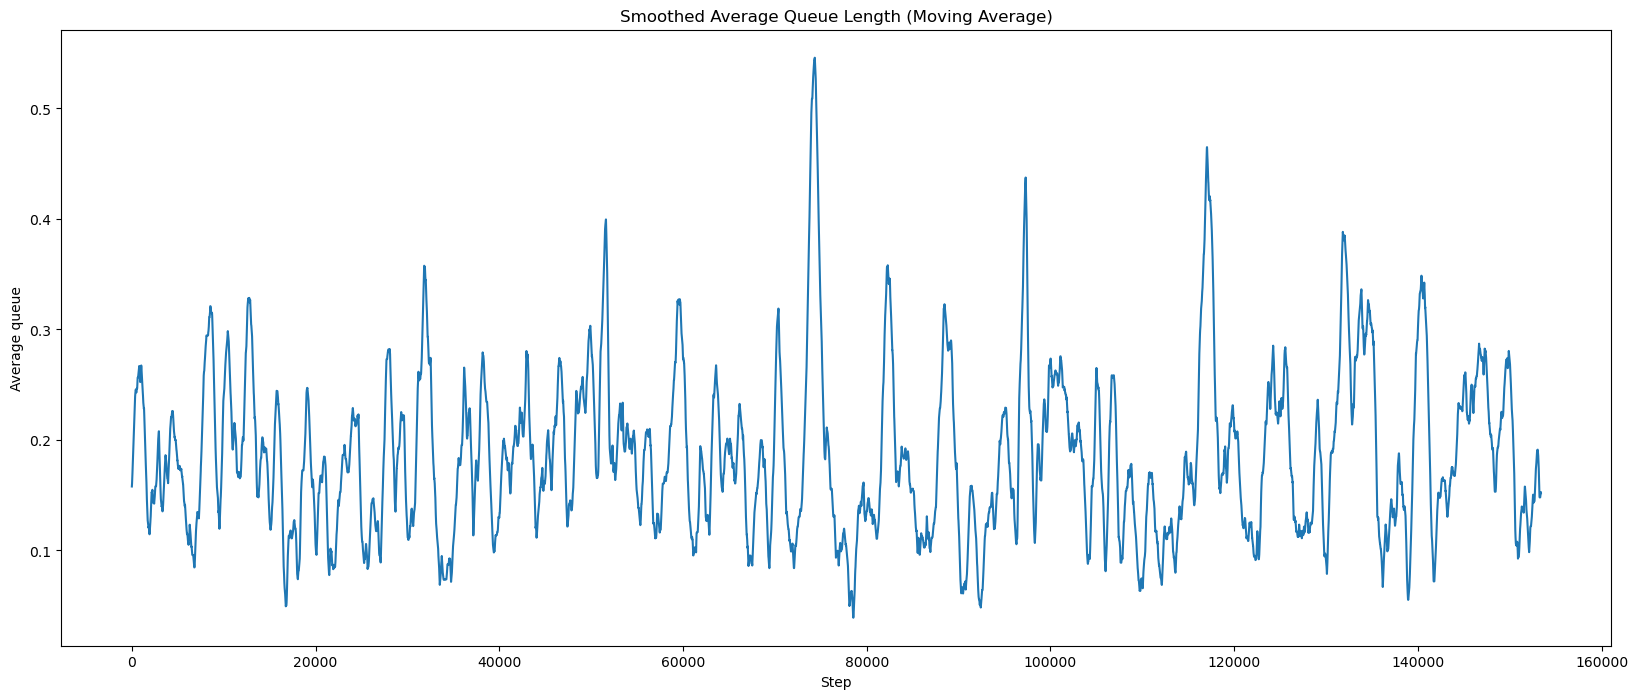

In [210]:
ma_queues = moving_average(all_queues_DQL)

plt.figure(figsize=(20, 8))
plt.plot(ma_queues)
plt.title("Smoothed Average Queue Length (Moving Average)")
plt.xlabel("Step")
plt.ylabel("Average queue")
plt.savefig("smoothed_reward_over_all_steps.png")

# Tensor Flow (to be removed)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from collections import deque

In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU detected: {gpus[0].name}")
else:
    print("No GPU detected, using CPU")

GPU detected: /physical_device:GPU:0


In [9]:
TRAIN_FREQ            = 20       # train once every 4 SIM steps
BATCH_SIZE            = 512      # minibatch size
TARGET_UPDATE_FREQ    = 500    # copy online→target after these many training calls
REPLAY_BUFFER_SIZE    = 100000

train_calls = 0
state_size = 13 


loss_fn = tf.keras.losses.MeanSquaredError()
ALPHA = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

2025-06-18 20:54:53.782108: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-18 20:54:53.782674: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-18 20:54:53.782701: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-18 20:54:53.783113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-18 20:54:53.783209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
Q_table = {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) : np.zeros(NUM_ACTIONS)}

In [34]:
def convert_state_to_array(state):
    ''' Convert the state tuple to a numpy array.'''
    return np.array(state, dtype=np.float32).reshape(1, -1)

def get_action_from_policy_DQN(state, EPSILON, model): 
    '''Balance exploration and exploitation.'''
    if random.random() < EPSILON:
        return int(random.choice(ACTIONS))
    else:
        Q_values = model.predict(convert_state_to_array(state), verbose=0)
        return np.argmax(Q_values[0])  # Exploit
    
def neural_network(input_shape, action_space, ALPHA = 0.01):
    ''' Create a simple feedforward neural network for Q-learning.'''
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    #model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(action_space, activation='linear'))
    
    model.compile(optimizer=optimizers.Adam(learning_rate=ALPHA), loss='huber_loss')
    return model


@tf.function
def train_step(q_net, target_net, states, actions, rewards, next_states, GAMMA = 0.95):
    # Predict Q(s',·) with target network
    Q_next = target_net(next_states, training=False)
    max_Q_next = tf.reduce_max(Q_next, axis=1)

    # Compute target values: y_j = r_j + gamma * max_a' Q_target(s', a')
    y = tf.convert_to_tensor(rewards, dtype=tf.float32) + GAMMA * max_Q_next

    with tf.GradientTape() as tape:
        Q_values = q_net(states, training=True)

        # Get the predicted Q-values for the actions actually taken
        indices = tf.stack([tf.range(tf.shape(actions)[0]), actions], axis=1)
        Q_selected = tf.gather_nd(Q_values, indices)

        # Compute loss
        loss = loss_fn(y, Q_selected)

    # Backpropagation
    gradients = tape.gradient(loss, q_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, q_net.trainable_variables))

    return loss


def train_on_batch(replay_buf, q_net, target_net, train_calls):

    minibatch = random.sample(replay_buf, BATCH_SIZE)
    states, actions, rewards, next_states = zip(*minibatch)

    # Preprocess data into tensors
    S  = tf.convert_to_tensor([np.array(s, dtype=np.float32) for s in states])
    S2 = tf.convert_to_tensor([np.array(s2, dtype=np.float32) for s2 in next_states])
    actions = tf.convert_to_tensor(actions, dtype=tf.int32)
    rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)

    # Run compiled training step
    loss = train_step(q_net, target_net, S, actions, rewards, S2)

    train_calls += 1

    if train_calls % (TARGET_UPDATE_FREQ // TRAIN_FREQ) == 0:
        target_net.set_weights(q_net.get_weights())


    if train_calls % 100 == 0:
        sample_Q = q_net(S[:1], training=False)[0]
        print(f"[Train #{train_calls}] Sample Q-values: {sample_Q.numpy()}, Best action: {tf.argmax(sample_Q).numpy()}, Loss: {loss:.4f}")

In [43]:
def run_simulation_DQL(TOTAL_STEPS, detector_ids, traffic_light_id, q_net, replay_buf, target_net, MIN_REPLAY_SIZE, EPSILON, training = True, Verbose = False):
    ''' Run the simulation for a specified number of steps.'''
    global last_switch_step
    step_history = []
    reward_history = []
    queue_history = []
    average_queue_length_for_step_history = []
    cumulative_reward = 0.0
    last_switch_step = 0
    step = 0
    train_calls = 0

    #model = neural_network((state_size,), action_space) 

    if training:
        MIN_EPSILON = 0.01
        EPSILON_DECAY = 0.99999230
    try: 
        while step < TOTAL_STEPS:


            state = get_state(detector_ids, traffic_light_id)
            
        
            # Choose an action based on the current state
            action_idx = get_action_from_policy_DQN(state, EPSILON, q_net)

            phase_code = PHASES[action_idx]
            current_phase = state[-1]
            action_applied = apply_action(step, current_phase)

            # Take the action in the environment
            if action_applied:
                if phase_code != current_phase:               
                    # set yellow first
                    current_phase = current_phase + 1
                    traci.trafficlight.setPhase(traffic_light_id, current_phase)  
                    #calculate new state and reward for 30 stepsù
                    for _ in range(30):
                        traci.simulationStep()
                        new_state = get_state(detector_ids, traffic_light_id)
                        reward = calculate_reward(new_state)
                        reward_history.append(reward)
                        cumulative_reward += reward
                        step += 1
                    
                    # Step to apply the new phase
                    traci.trafficlight.setPhase(traffic_light_id, phase_code)
                    traci.simulationStep()
                    new_state = get_state(detector_ids, traffic_light_id)
                    reward = calculate_reward(new_state)
                    cumulative_reward += reward
                    step += 1
                    reward_history.append(reward)
                    last_switch_step = step
                    if training:
                        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY) #type:ignore
                        replay_buf.append((state, action_idx, reward, new_state))
                        if step % TRAIN_FREQ == 0 and len(replay_buf) >= MIN_REPLAY_SIZE:
                            train_on_batch(replay_buf, q_net, target_net, train_calls)  # Train the model on a batch from the replay buffer
                    elif not training and step%100 == 0:
                        Q_values = q_net.predict(convert_state_to_array(state), verbose=0)[0]
                        print(f"[Step {step}] Q-values: {Q_values}, Chosen Action: {action_idx}")

                
                elif phase_code == current_phase:  #type: ignore
                    traci.simulationStep()
                    # 3) observe next state & reward
                    new_state = get_state(detector_ids, traffic_light_id)
                    reward = calculate_reward(new_state)
                    cumulative_reward += reward
                    reward_history.append(reward)
                    step += 1
                    #last_switch_step = step

                    # 5) decay epsilon
                    if training:
                        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY) #type:ignore
                        replay_buf.append((state, action_idx, reward, new_state))
                        if step % TRAIN_FREQ == 0 and len(replay_buf) >= MIN_REPLAY_SIZE:
                            train_on_batch(replay_buf, q_net, target_net, train_calls)  # Train the model on a batch from the replay buffer
                    elif not training and step%100 == 0:
                        Q_values = q_net.predict(convert_state_to_array(state), verbose=0)[0]
            else:
                traci.simulationStep()

                # 3) observe next state & reward
                new_state = get_state(detector_ids, traffic_light_id)
                reward = calculate_reward(new_state)
                cumulative_reward += reward
                reward_history.append(reward)
                step += 1

                if training:
                    EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)
        

            
            # Store step and reward history
            step_history.append(step)

            queue_lengths = [get_queue_length(det) for det in detector_ids]
            queue_history.append(queue_lengths)
            average_queue_length_for_step = sum(queue_lengths) / len(queue_lengths) if queue_lengths else 0
            average_queue_length_for_step_history.append(average_queue_length_for_step)
            

            if Verbose:
                if step % 6000 == 0:
                    #updated_q_vals = model.predict(convert_state_to_array(state), verbose=0)[0]
                    print(f"{Y}Step {step}/{TOTAL_STEPS}, Epsilon: {EPSILON:.4f}, Cumulative Reward: {cumulative_reward:.2f}{E}, Queue Lengths: {new_state[:12]}, Action: {action_idx}")
                    #step_history.append(step)
                    #reward_history.append(cumulative_reward)
                    #queue_history.append(sum(new_state[:-1]))  # sum of queue lengths

        average_queue_length = np.mean([sum(q) if isinstance(q, (list, tuple)) else q for q in queue_history])
        print(f"{Y}Cumulative Reward: {cumulative_reward:.2f}, Average Queue Length: {average_queue_length:.2f}{E}, Epsilon: {EPSILON:.4f}")

    except KeyboardInterrupt:
        print(f"{Y}Simulation interrupted by user.{E}")
    
    finally:
        traci.close()
        
    
    return step_history, reward_history, queue_history, average_queue_length_for_step_history, cumulative_reward, average_queue_length, EPSILON


In [46]:
q_net      = neural_network(input_shape=(state_size,), action_space=NUM_ACTIONS)
target_net = neural_network(input_shape=(state_size,), action_space=NUM_ACTIONS)
target_net.set_weights(q_net.get_weights())
replay_buf = deque(maxlen=REPLAY_BUFFER_SIZE)
train_calls = 0  # count how many minibatch trainings we've done

EPSILON = 1
for i in range(10):
    print(f"{Y}Starting simulation iteration {i}{E}")
    Sumo_config = Sumo_init(i, Visualize=False)
    step_history, reward_history, queue_history, average_queue_length_for_step_history, cumulative_reward, average_queue_length, EPSILON = run_simulation_DQL(20000, detector_ids, traffic_light_id, q_net, replay_buf,target_net,1000, EPSILON, Verbose=True)
    print('--' * 50)
    #traci.close()

print(f"{Y}Simulation completed.{E}")

Starting simulation iteration 0


Step 6000/20000, Epsilon: 0.9648, Cumulative Reward: -26001.00, Queue Lengths: (0, 1, 1, 0, 0, 0, 1, 3, 1, 0, 0, 0), Action: 0
Step 12000/20000, Epsilon: 0.9311, Cumulative Reward: -64649.00, Queue Lengths: (0, 0, 0, 1, 2, 0, 0, 0, 0, 3, 0, 0), Action: 2
Step 18000/20000, Epsilon: 0.8986, Cumulative Reward: -89336.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 2
Cumulative Reward: -98711.00, Average Queue Length: 4.71, Epsilon: 0.8879
----------------------------------------------------------------------------------------------------
Starting simulation iteration 1


Step 6000/20000, Epsilon: 0.8567, Cumulative Reward: -21313.00, Queue Lengths: (0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0), Action: 3
Step 12000/20000, Epsilon: 0.8267, Cumulative Reward: -41427.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0), Action: 0
Cumulative Reward: -77594.00, Average Queue Length: 3.69, Epsilon: 0.7884
----------------------------------------------------------------------------------------------------
Starting simulation iteration 2


Step 6000/20000, Epsilon: 0.7606, Cumulative Reward: -27943.00, Queue Lengths: (0, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0), Action: 3
Step 12000/20000, Epsilon: 0.7341, Cumulative Reward: -55772.00, Queue Lengths: (3, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0), Action: 2
Cumulative Reward: -97069.00, Average Queue Length: 4.64, Epsilon: 0.7000
----------------------------------------------------------------------------------------------------
Starting simulation iteration 3


Step 6000/20000, Epsilon: 0.6754, Cumulative Reward: -18601.00, Queue Lengths: (1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0), Action: 0
Step 12000/20000, Epsilon: 0.6518, Cumulative Reward: -47428.00, Queue Lengths: (0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0), Action: 0
Step 18000/20000, Epsilon: 0.6289, Cumulative Reward: -87536.00, Queue Lengths: (1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0), Action: 2
Cumulative Reward: -96943.00, Average Queue Length: 4.64, Epsilon: 0.6215
----------------------------------------------------------------------------------------------------
Starting simulation iteration 4


Step 6000/20000, Epsilon: 0.5996, Cumulative Reward: -31893.00, Queue Lengths: (0, 0, 0, 2, 1, 0, 1, 0, 0, 1, 0, 0), Action: 2
Step 12000/20000, Epsilon: 0.5787, Cumulative Reward: -58708.00, Queue Lengths: (1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1), Action: 0
Step 18000/20000, Epsilon: 0.5583, Cumulative Reward: -86651.00, Queue Lengths: (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0), Action: 0
Cumulative Reward: -91942.00, Average Queue Length: 4.40, Epsilon: 0.5518
----------------------------------------------------------------------------------------------------
Starting simulation iteration 5


Step 6000/20000, Epsilon: 0.5324, Cumulative Reward: -24244.00, Queue Lengths: (2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 3
Step 12000/20000, Epsilon: 0.5137, Cumulative Reward: -51380.00, Queue Lengths: (0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1), Action: 0
Cumulative Reward: -83289.00, Average Queue Length: 3.95, Epsilon: 0.4899
----------------------------------------------------------------------------------------------------
Starting simulation iteration 6


Step 6000/20000, Epsilon: 0.4727, Cumulative Reward: -24323.00, Queue Lengths: (1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0), Action: 3
Step 12000/20000, Epsilon: 0.4562, Cumulative Reward: -41643.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 3
Cumulative Reward: -63254.00, Average Queue Length: 2.97, Epsilon: 0.4350
----------------------------------------------------------------------------------------------------
Starting simulation iteration 7


Step 6000/20000, Epsilon: 0.4197, Cumulative Reward: -25636.00, Queue Lengths: (0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Step 12000/20000, Epsilon: 0.4050, Cumulative Reward: -48164.00, Queue Lengths: (1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0), Action: 1
Step 18000/20000, Epsilon: 0.3909, Cumulative Reward: -64974.00, Queue Lengths: (0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0), Action: 1
Cumulative Reward: -70980.00, Average Queue Length: 3.33, Epsilon: 0.3862
----------------------------------------------------------------------------------------------------
Starting simulation iteration 8


Step 6000/20000, Epsilon: 0.3727, Cumulative Reward: -13686.00, Queue Lengths: (0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 0
Step 12000/20000, Epsilon: 0.3596, Cumulative Reward: -36187.00, Queue Lengths: (0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0), Action: 1
Step 18000/20000, Epsilon: 0.3471, Cumulative Reward: -55907.00, Queue Lengths: (0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 3
Cumulative Reward: -62115.00, Average Queue Length: 2.91, Epsilon: 0.3429
----------------------------------------------------------------------------------------------------
Starting simulation iteration 9


Step 6000/20000, Epsilon: 0.3309, Cumulative Reward: -13415.00, Queue Lengths: (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 3
Step 12000/20000, Epsilon: 0.3193, Cumulative Reward: -29255.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0), Action: 2
Cumulative Reward: -67696.00, Average Queue Length: 3.17, Epsilon: 0.3045
----------------------------------------------------------------------------------------------------
Simulation completed.


In [47]:
#print trained weights
print(f"{Y}Trained Q-network weights:{E}")
for layer in q_net.layers:
    weights = layer.get_weights()
    print(f"{layer.name} weights: {weights}")

Trained Q-network weights:
dense_40 weights: [array([[ 2.91371197e-02,  2.66996533e-01,  1.02033019e-02,
        -1.81677453e-02, -2.65103638e-01,  4.13743779e-02,
         1.49715200e-01,  1.38635784e-01,  4.76603732e-02,
         1.63625792e-01, -3.85314614e-01, -1.94703445e-01,
         6.06624261e-02,  9.53429490e-02,  2.10951030e-01,
        -7.12291598e-02,  3.77891302e-01, -5.68842776e-02,
         2.58570850e-01, -2.75205314e-01, -2.56939530e-01,
         1.27323195e-01,  2.76238561e-01,  4.80466895e-02,
         1.09590795e-02,  5.24201170e-02, -4.26043034e-01,
         3.41229409e-01, -1.94143027e-01, -1.57339908e-02,
         1.26733139e-01,  2.10505072e-03, -1.52063789e-02,
         3.15370262e-01, -4.25011255e-02,  1.82166934e-01,
        -1.02727391e-01,  9.00006592e-02,  2.48839498e-01,
         4.59235758e-01,  1.53992400e-01, -7.47861862e-02,
         5.10117784e-02, -1.52751580e-01,  2.40740880e-01,
        -6.08658371e-03,  1.22100953e-03, -2.18912319e-04,
        -1

In [48]:
eval_q_net = neural_network(input_shape=(state_size,), action_space=NUM_ACTIONS)
eval_q_net.set_weights(q_net.get_weights())
print(eval_q_net.summary())  # Print the model summary
print

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,156 (4.52 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 0 (0.00 B)

None


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [56]:
average_reward_DQL = []
average_queue_length_on_seeds_DQL = []
all_queues_DQL = []
all_rewards_DQL = []
for i in range(10,20):
    print(f"{Y}Running simulation with seed {i}{E}")
    Sumo_init(i)
    step_history_DQL, reward_history_DQL, queue_history_DQL, average_queue_length_for_step_history_DQL, cumulative_reward_DQL, average_queue_length_DQL, EPSILON = run_simulation_DQL(20000, detector_ids, traffic_light_id, q_net, replay_buf,target_net,1000, EPSILON=0.0, training= False,Verbose=True)
    average_reward_DQL.append(cumulative_reward)
    average_queue_length_on_seeds_DQL.append(average_queue_length)
    print('--' * 50)
    all_queues_DQL.extend(average_queue_length_for_step_history)
    all_rewards_DQL.extend(reward_history)

# Print the average cumulative reward and average queue length over 10 runs
print(f"{Y}Average Cumulative Reward over 10 runs: {np.mean(average_reward_DQL):.2f}, Standard Deviation: {np.std(average_reward_DQL):.2f}{E}")
#compute standard deviation of average reward
print(f"{Y}Average Queue Length over 10 runs: {np.mean(average_queue_length_on_seeds_DQL):.2f}{E}")

Running simulation with seed 10


[Step 3600] Q-values: [-3.1411998 -3.2085657 -2.938182  -2.0957127], Chosen Action: 3
Step 6000/20000, Epsilon: 0.0000, Cumulative Reward: -21908.00, Queue Lengths: (0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0), Action: 3
Step 12000/20000, Epsilon: 0.0000, Cumulative Reward: -56002.00, Queue Lengths: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Action: 3
Step 18000/20000, Epsilon: 0.0000, Cumulative Reward: -87318.00, Queue Lengths: (2, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0), Action: 0
Cumulative Reward: -95326.00, Average Queue Length: 4.56, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 11


[Step 6000] Q-values: [-6.3379803 -7.439139  -7.6674666 -7.0980372], Chosen Action: 0
Step 6000/20000, Epsilon: 0.0000, Cumulative Reward: -35282.00, Queue Lengths: (0, 1, 1, 0, 0, 0, 1, 3, 3, 0, 0, 0), Action: 0
Step 12000/20000, Epsilon: 0.0000, Cumulative Reward: -66930.00, Queue Lengths: (1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0), Action: 3
Step 18000/20000, Epsilon: 0.0000, Cumulative Reward: -97288.00, Queue Lengths: (1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0), Action: 3
Cumulative Reward: -106991.00, Average Queue Length: 5.17, Epsilon: 0.0000
----------------------------------------------------------------------------------------------------
Running simulation with seed 12


Simulation interrupted by user.


UnboundLocalError: cannot access local variable 'average_queue_length' where it is not associated with a value